# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# Aging2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
Aging2_twas = fread("~/project/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [5]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [6]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [6]:
head(Aging2_twas)
dim(Aging2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.4422873,0.65828134,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.5153586,0.60630249,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,0.3763701,0.70664179,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.4166957,0.67690100,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.007872702,5.201216e-02,2.3533373,0.01860575,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,2.2734046,0.02300181,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 920648     19

In [6]:
# Strong and reliable TWAS signals:
Aging2_twas_filtered <- Aging2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging2_block = unique(Aging2_twas_filtered$block)

In [7]:
dim(Aging2_twas_filtered)

[1] 1077   19

In [9]:
# R Script to Process TWAS/SuSiE Fine-mapping Results and Match with GWAS
# Extracts variants in credible sets and identifies top GWAS variant per gene-context-cohort

# Step 1: Load necessary libraries
library(purrr)
library(stringr)
library(data.table)
library(dplyr)

# --- Helper Function for CS Variant Selection (No PIP filtering) ---
select_all_cs_variants <- function(df, gene_id) {
    # Select ALL variants that are in any credible set (coverage > 0 at any level)
    # No PIP filtering - just get CS membership
    
    if (nrow(df) == 0) {
        warning(paste("No variants found for gene:", gene_id))
        return(NULL)
    }
    
    # Validate required columns
    required_cols <- c("cs_coverage_0.95", "cs_coverage_0.7", "cs_coverage_0.5")
    missing_cols <- setdiff(required_cols, colnames(df))
    if (length(missing_cols) > 0) {
        warning(paste("Gene", gene_id, ": Missing required columns:", paste(missing_cols, collapse = ", ")))
        return(NULL)
    }
    
    # Select ALL variants that are in ANY credible set (any coverage > 0)
    cs_variants <- df |> 
        filter(cs_coverage_0.95 > 0 | cs_coverage_0.7 > 0 | cs_coverage_0.5 > 0)
    
    if (nrow(cs_variants) == 0) {
        warning(paste("Gene", gene_id, ": No variants with credible set coverage > 0"))
        return(NULL)
    }
    
    # Determine highest coverage level for each variant
    cs_variants <- cs_variants |>
        mutate(
            highest_cs_level = case_when(
                cs_coverage_0.95 > 0 ~ "cs_0.95",
                cs_coverage_0.7 > 0 ~ "cs_0.7",
                cs_coverage_0.5 > 0 ~ "cs_0.5",
                TRUE ~ "none"
            )
        )
    
    message(paste("Gene", gene_id, ": Selected", nrow(cs_variants), "variants in credible sets"))
    
    return(cs_variants)
}

# --- Define Cohort Information ---
cohorts <- list(
    KNIGHT = list(
        name = "KNIGHT",
        weight_db_path = "~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    MSBB = list(
        name = "MSBB", 
        weight_db_path = "~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP = list(
        name = "ROSMAP",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP_MEGA = list(
        name = "ROSMAP_MEGA",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv"
    )
)

# --- Load GWAS Metadata ---
gwas_meta_path <- "~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_gwas_meta_by_chrom.tsv"
cat("Loading GWAS metadata from:", gwas_meta_path, "\n")
gwas_meta <- fread(gwas_meta_path)
cat(sprintf("Loaded GWAS metadata for %d chromosomes\n", nrow(gwas_meta)))

# Create a lookup for GWAS files by chromosome
gwas_files_by_chrom <- setNames(
    paste0("~/data/", gwas_meta$file_path),
    gwas_meta$chrom
)

# --- Function to Load GWAS Data for Specific Chromosome ---
load_gwas_for_chrom <- function(chrom, gwas_lookup) {
    if (!as.character(chrom) %in% names(gwas_lookup)) {
        warning(paste("No GWAS file found for chromosome:", chrom))
        return(NULL)
    }
    
    gwas_file <- gwas_lookup[[as.character(chrom)]]
    cat(sprintf("  Loading GWAS data for chr%s from: %s\n", chrom, gwas_file))
    
    tryCatch({
        # Load GWAS data
        gwas_data <- fread(gwas_file, select = c("variant_id", "z", "P"))
        
        # Calculate p-value from Z-score if P column is missing or NA
        if (!"P" %in% colnames(gwas_data) || all(is.na(gwas_data$P))) {
            cat("    Calculating p-values from Z-scores\n")
            gwas_data$P <- 2 * pnorm(-abs(gwas_data$z))
        }
        
        # Remove variants with missing p-values
        gwas_data <- gwas_data |> filter(!is.na(P))
        
        cat(sprintf("    Loaded %d variants with valid p-values for chr%s\n", 
                   nrow(gwas_data), chrom))
        return(gwas_data)
    }, error = function(e) {
        warning(paste("Error loading GWAS file for chr", chrom, ":", e$message))
        return(NULL)
    })
}

# --- Main Processing Logic ---

# Initialize master list to store results from all cohorts
all_cohorts_results <- list()
master_processing_summary <- list(
    cohorts_processed = 0,
    total_genes_processed = 0,
    genes_with_cs = 0,
    genes_with_gwas_match = 0,
    total_cs_variants = 0,
    total_matched_variants = 0,
    errors = character(0)
)

cat("=== Starting Multi-Cohort TWAS/SuSiE Processing with GWAS Integration ===\n")
cat("Cohorts to process:", length(cohorts), "\n")
cat("Total regions per cohort:", length(Aging2_block), "\n\n")

# Loop through each cohort
for (cohort_idx in seq_along(cohorts)) {
    cohort_info <- cohorts[[cohort_idx]]
    cohort_name <- cohort_info$name
    weight_db_path <- cohort_info$weight_db_path
    
    cat(sprintf("=== PROCESSING COHORT %d/%d: %s ===\n", cohort_idx, length(cohorts), cohort_name))
    
    # Initialize cohort-specific tracking
    cohort_results <- list()
    
    tryCatch({
        # Load weight database list for current cohort
        cat(sprintf("Loading weight database metadata: %s\n", weight_db_path))
        weight_db_list <- fread(weight_db_path)
        cat(sprintf("Loaded %d weight database entries for %s\n", nrow(weight_db_list), cohort_name))
        
        master_processing_summary$cohorts_processed <- master_processing_summary$cohorts_processed + 1
        
        # Loop through each specified region/block
        for (region_idx in seq_along(Aging2_block)) {
            region_db <- Aging2_block[region_idx]
            
            cat(sprintf("  Processing region %d/%d: %s\n", region_idx, length(Aging2_block), region_db))
            
            tryCatch({
                # Filter for significant genes within the current block
                Aging2_multigene_per_block <- Aging2_twas_filtered |> 
                    filter(block == region_db)
                
                contexts_in_region <- unique(Aging2_multigene_per_block$context)
                
                cat(sprintf("    Found genes across %d contexts in region %s\n", 
                           length(contexts_in_region), region_db))
                
                if (length(contexts_in_region) == 0) {
                    cat("    No contexts found, skipping region\n")
                    next
                }
                
                # Loop through each context in the region
                for (context_name in contexts_in_region) {
                    cat(sprintf("      Processing context: %s\n", context_name))
                    
                    # Filter for genes in this specific context
                    genes_in_context <- Aging2_multigene_per_block |> 
                        filter(context == context_name) |> 
                        pull(molecular_id) |> 
                        unique()
                    
                    cat(sprintf("        %d genes in this context\n", length(genes_in_context)))
                    
                    # Loop through each gene in the current context
                    for (gene_idx in seq_along(genes_in_context)) {
                        gene_db <- genes_in_context[gene_idx]
                        master_processing_summary$total_genes_processed <- 
                            master_processing_summary$total_genes_processed + 1
                        
                        cat(sprintf("          Processing gene %d/%d: %s\n", 
                                   gene_idx, length(genes_in_context), gene_db))
                        
                        tryCatch({
                            # Get the database paths for the weights
                            weight_db_matches <- weight_db_list |> filter(region_id == gene_db)
                            
                            if (nrow(weight_db_matches) == 0) {
                                next
                            }
                            
                            weight_dbs <- weight_db_matches |> 
                                pull(original_data) |> 
                                str_split(",") |> 
                                unlist()
                            
                            # Load the weights for the current gene
                            twas_weights_results <- load_twas_weights(
                                weight_dbs, 
                                variable_name_obj = "variant_names", 
                                susie_obj = "susie_weights_intermediate",
                                twas_weights_table = "twas_weights"
                            )
                            
                            # Validate results
                            if (!is.list(twas_weights_results) || 
                                is.null(twas_weights_results$susie_results) ||
                                length(twas_weights_results$susie_results) == 0) {
                                next
                            }
                            
                            susie_res <- twas_weights_results$susie_results[[1]]
                            
                            if (is.null(susie_res$top_loci) || nrow(susie_res$top_loci) == 0) {
                                next
                            }
                            
                            df <- as.data.frame(susie_res$top_loci)
                            
                            # Use CS selection function to get ALL CS variants
                            gene_context_cohort_id <- paste(gene_db, context_name, cohort_name, sep = "_")
                            cs_variants_df <- select_all_cs_variants(df, gene_context_cohort_id)
                            
                            if (is.null(cs_variants_df) || nrow(cs_variants_df) == 0) {
                                next
                            }
                            
                            master_processing_summary$genes_with_cs <- 
                                master_processing_summary$genes_with_cs + 1
                            master_processing_summary$total_cs_variants <- 
                                master_processing_summary$total_cs_variants + nrow(cs_variants_df)
                            
                            # Extract chromosome from variant_id (first element before ':')
                            # Remove "chr" prefix to match GWAS format
                            cs_variants_df$variant_id_gwas <- gsub("^chr", "", cs_variants_df$variant_id)
                            cs_variants_df$chrom <- sapply(strsplit(cs_variants_df$variant_id_gwas, ":"), `[`, 1)
                            
                            # Get unique chromosomes in this gene's CS variants
                            unique_chroms <- unique(cs_variants_df$chrom)
                            cat(sprintf("            Found CS variants on chromosomes: %s\n", 
                                       paste(unique_chroms, collapse = ", ")))
                            
                            # Load GWAS data for each chromosome and match variants
                            gwas_matched_variants <- list()
                            
                            for (chrom in unique_chroms) {
                                gwas_data <- load_gwas_for_chrom(chrom, gwas_files_by_chrom)
                                
                                if (is.null(gwas_data)) {
                                    next
                                }
                                
                                # Filter CS variants for this chromosome
                                cs_variants_chrom <- cs_variants_df |> filter(chrom == !!chrom)
                                
                                # Match with GWAS data using the modified variant_id (without "chr")
                                matched <- cs_variants_chrom |>
                                    inner_join(gwas_data, by = c("variant_id_gwas" = "variant_id"))
                                
                                if (nrow(matched) > 0) {
                                    gwas_matched_variants[[as.character(chrom)]] <- matched
                                    cat(sprintf("              Chr%s: Matched %d/%d CS variants with GWAS\n",
                                               chrom, nrow(matched), nrow(cs_variants_chrom)))
                                }
                            }
                            
                            # Combine all matched variants across chromosomes
                            if (length(gwas_matched_variants) == 0) {
                                cat("            No GWAS matches found for any CS variants\n")
                                next
                            }
                            
                            all_matched <- bind_rows(gwas_matched_variants)
                            master_processing_summary$total_matched_variants <- 
                                master_processing_summary$total_matched_variants + nrow(all_matched)
                            
                            # Select variant with smallest GWAS p-value
                            top_variant <- all_matched |>
                                arrange(P) |>
                                slice(1)
                            
                            # Add metadata
                            top_variant$gene_id <- gene_db
                            top_variant$block_id <- region_db
                            top_variant$context <- context_name
                            top_variant$cohort <- cohort_name
                            top_variant$n_cs_variants <- nrow(cs_variants_df)
                            top_variant$n_matched_variants <- nrow(all_matched)
                            
                            # Create unique key for gene-context-cohort combination
                            unique_key <- paste(gene_db, context_name, cohort_name, sep = "_")
                            
                            # Store the result
                            cohort_results[[unique_key]] <- top_variant
                            master_processing_summary$genes_with_gwas_match <- 
                                master_processing_summary$genes_with_gwas_match + 1
                            
                            cat(sprintf("            ✓ Top variant: %s (P=%.2e) for gene %s\n", 
                                       top_variant$variant_id, top_variant$P, gene_db))
                            
                        }, error = function(e) {
                            error_msg <- paste("Gene", gene_db, "context", context_name, 
                                             "cohort", cohort_name, "error:", e$message)
                            master_processing_summary$errors <- 
                                c(master_processing_summary$errors, error_msg)
                        })
                    }
                }
                
            }, error = function(e) {
                error_msg <- paste("Region", region_db, "cohort", cohort_name, "error:", e$message)
                master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
            })
        }
        
        # Store cohort results
        all_cohorts_results[[cohort_name]] <- cohort_results
        
        cat(sprintf("  Completed cohort %s: %d genes with GWAS-matched top variants\n\n", 
                   cohort_name, length(cohort_results)))
        
    }, error = function(e) {
        error_msg <- paste("Cohort", cohort_name, "error:", e$message)
        master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
    })
}

# --- Final Results Compilation ---
cat("=== PROCESSING SUMMARY ===\n")
cat("Total gene-context-cohort combinations processed:", 
    master_processing_summary$total_genes_processed, "\n")
cat("Combinations with credible sets:", master_processing_summary$genes_with_cs, "\n")
cat("Combinations with GWAS-matched top variant:", 
    master_processing_summary$genes_with_gwas_match, "\n")
cat("Total CS variants across all combinations:", 
    master_processing_summary$total_cs_variants, "\n")
cat("Total CS variants matched with GWAS:", 
    master_processing_summary$total_matched_variants, "\n")

# Flatten all cohort results into final data frame
all_results_flattened <- list()
for (cohort_name in names(all_cohorts_results)) {
    cohort_data <- all_cohorts_results[[cohort_name]]
    all_results_flattened <- c(all_results_flattened, cohort_data)
}

final_df <- bind_rows(all_results_flattened)

if (nrow(final_df) > 0) {
    cat(sprintf("\n=== FINAL RESULTS ===\n"))
    cat(sprintf("Created data frame with %d top GWAS variants (one per gene-context-cohort)\n", 
               nrow(final_df)))
    
    # Select final columns
    final_df <- final_df |>
        select(
            variant_id_qtl = variant_id,
            variant_id_gwas,
            chrom,
            gene_id,
            context,
            cohort,
            block_id,
            gwas_p = P,
            gwas_z = z,
            betahat,
            sebetahat,
            highest_cs_level,
            n_cs_variants,
            n_matched_variants
        )
    
    # Summary statistics
    cat("\nSummary by cohort:\n")
    cohort_summary <- final_df |>
        group_by(cohort) |>
        summarise(
            n_genes = n(),
            median_gwas_p = median(gwas_p),
            mean_cs_variants = mean(n_cs_variants),
            .groups = "drop"
        )
    print(cohort_summary)
    
    cat("\nSummary by context:\n")
    context_summary <- final_df |>
        group_by(context) |>
        summarise(
            n_genes = n(),
            median_gwas_p = median(gwas_p),
            .groups = "drop"
        )
    print(context_summary)
    
    cat("\n=== SAMPLE RESULTS (first 10 rows) ===\n")
    print(head(final_df, 10))
    
    cat("\n=== Top 10 most significant GWAS variants ===\n")
    print(final_df |> arrange(gwas_p) |> head(10))
    
} else {
    cat("\n=== NO RESULTS ===\n")
    cat("No top variants identified. Check errors above.\n")
}

Loading GWAS metadata from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_gwas_meta_by_chrom.tsv 
Loaded GWAS metadata for 22 chromosomes
=== Starting Multi-Cohort TWAS/SuSiE Processing with GWAS Integration ===
Cohorts to process: 4 
Total regions per cohort: 35 

=== PROCESSING COHORT 1/4: KNIGHT ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 16852 weight database entries for KNIGHT
  Processing region 1/35: chr10_123788803_125506866
    Found genes across 10 contexts in region chr10_123788803_125506866
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Knight_eQTL_brain_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_36_MSBB_eQTL_KNIGHT : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr10:124605322:TG:T (P=7.11e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_36_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_44_MSBB_eQTL_KNIGHT : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr10:124605322:TG:T (P=7.11e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_44_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_10_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_22_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000019995


Gene ENSG00000019995_monocyte_ROSMAP_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr10:124985898:CTTCT:C (P=3.92e-01) for gene ENSG00000019995
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_monocyte_ROSMAP_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_AC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
          Processing gene 2/2: ENSG00000258539
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_DLPFC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
          Processing gene 2/2: ENSG00000258539
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Exc_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_PCC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:124829420:G:A (P=4.25e-13) for gene ENSG00000203791
  Processing region 2/35: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”


      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_KNIGHT : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 19/19 CS variants with GWAS
            ✓ Top variant: chr12:117451964:T:C (P=8.04e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_PCC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/4: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174989
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
  Processing region 3/35: chr12_61991992_65677087
    Found genes across 17 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000184575
      Processing context: BM_44_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_BM_44_MSBB_eQTL_KNIGHT : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 5/7 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=8.09e-04) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_BM_44_MSBB_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_BM_44_MSBB_eQTL_KNIGHT : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 7/9 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=8.09e-04) for gene ENSG00000288591
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000135677
          Processing gene 2/2: ENSG00000156076
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099


Gene ENSG00000174099_BM_10_MSBB_eQTL_KNIGHT : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 51/51 CS variants with GWAS
            ✓ Top variant: chr12:65469010:T:C (P=2.25e-19) for gene ENSG00000174099
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000288591


Gene ENSG00000288591_BM_36_MSBB_eQTL_KNIGHT : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 7/9 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=8.09e-04) for gene ENSG00000288591
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_KNIGHT : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 5/7 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=8.09e-04) for gene ENSG00000111490
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Gene ENSG00000174099_Exc_mega_eQTL_KNIGHT : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 51/51 CS variants with GWAS
            ✓ Top variant: chr12:65469010:T:C (P=2.25e-19) for gene ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Gene ENSG00000174099_Inh_mega_eQTL_KNIGHT : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 51/51 CS variants with GWAS
            ✓ Top variant: chr12:65469010:T:C (P=2.25e-19) for gene ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Inh_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 34/34 CS variants with GWAS
            ✓ Top variant: chr12:65281848:T:C (P=2.57e-19) for gene ENSG00000174106
  Processing region 4/35: chr16_29685831_46381513
    Found genes across 23 contexts in region chr16_29685831_46381513
      Processing context: Knight_eQTL_brain
        4 genes in this context
          Processing gene 1/4: ENSG00000090238


Gene ENSG00000090238_Knight_eQTL_brain_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/4: ENSG00000102882
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Knight_eQTL_brain_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000174939


Gene ENSG00000174939_Knight_eQTL_brain_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
      Processing context: BM_10_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Gene ENSG00000090238_BM_10_MSBB_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/7: ENSG00000102882
          Processing gene 3/7: ENSG00000102886


Gene ENSG00000102886_BM_10_MSBB_eQTL_KNIGHT : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/27 CS variants with GWAS
            ✓ Top variant: chr16:30164188:C:T (P=2.90e-10) for gene ENSG00000102886
          Processing gene 4/7: ENSG00000149922
          Processing gene 5/7: ENSG00000149932
          Processing gene 6/7: ENSG00000169592


Gene ENSG00000169592_BM_10_MSBB_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 7/7: ENSG00000198064
      Processing context: BM_44_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Gene ENSG00000090238_BM_44_MSBB_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/7: ENSG00000102882
          Processing gene 3/7: ENSG00000149922
          Processing gene 4/7: ENSG00000149932
          Processing gene 5/7: ENSG00000174939


Gene ENSG00000174939_BM_44_MSBB_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 6/7: ENSG00000185905


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185905_BM_44_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 7/7: ENSG00000198064
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882
          Processing gene 2/4: ENSG00000149922
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_BM_22_MSBB_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000198064
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000102882
          Processing gene 2/2: ENSG00000198064
      Processing context: MSBB_BM36_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


Gene ENSG00000149927_MSBB_BM36_pQTL_chr16_Q14183_KNIGHT : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:30641106:C:T (P=1.42e-01) for gene ENSG00000149927
      Processing context: MSBB_BM36_pQTL_chr16_Q99611
        1 genes in this context
          Processing gene 1/1: ENSG00000179918
      Processing context: Exc_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_Exc_DeJager_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000102879
          Processing gene 3/5: ENSG00000102882
          Processing gene 4/5: ENSG00000149927


Gene ENSG00000149927_Exc_DeJager_eQTL_KNIGHT : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:30641106:C:T (P=1.42e-01) for gene ENSG00000149927
          Processing gene 5/5: ENSG00000169592


Gene ENSG00000169592_Exc_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
      Processing context: Inh_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Gene ENSG00000090238_Inh_DeJager_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/3: ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Gene ENSG00000169592_Inh_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_Oli_DeJager_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000169592


Gene ENSG00000169592_Oli_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 3/5: ENSG00000174938
          Processing gene 4/5: ENSG00000174939


Gene ENSG00000174939_Oli_DeJager_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 5/5: ENSG00000174943
      Processing context: PCC_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_PCC_DeJager_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000102882
          Processing gene 3/5: ENSG00000149922
          Processing gene 4/5: ENSG00000149932
          Processing gene 5/5: ENSG00000174943
      Processing context: AC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882
          Processing gene 2/9: ENSG00000149922
          Processing gene 3/9: ENSG00000149923


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149923_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 4/9: ENSG00000149927


Gene ENSG00000149927_AC_DeJager_eQTL_KNIGHT : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:30641106:C:T (P=1.42e-01) for gene ENSG00000149927
          Processing gene 5/9: ENSG00000149930
          Processing gene 6/9: ENSG00000149932
          Processing gene 7/9: ENSG00000169592


Gene ENSG00000169592_AC_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 8/9: ENSG00000174939


Gene ENSG00000174939_AC_DeJager_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 9/9: ENSG00000174943
      Processing context: DLPFC_Bennett_pQTL_chr16_P27361
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
      Processing context: DLPFC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882
          Processing gene 2/9: ENSG00000102886


Gene ENSG00000102886_DLPFC_DeJager_eQTL_KNIGHT : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/27 CS variants with GWAS
            ✓ Top variant: chr16:30164188:C:T (P=2.90e-10) for gene ENSG00000102886
          Processing gene 3/9: ENSG00000149930
          Processing gene 4/9: ENSG00000149932
          Processing gene 5/9: ENSG00000169592


Gene ENSG00000169592_DLPFC_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 6/9: ENSG00000174939


Gene ENSG00000174939_DLPFC_DeJager_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 7/9: ENSG00000174943
          Processing gene 8/9: ENSG00000198064
          Processing gene 9/9: ENSG00000103507


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000103507_DLPFC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


Gene ENSG00000149927_DLPFC_Bennett_pQTL_chr16_Q14183_KNIGHT : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:30641106:C:T (P=1.42e-01) for gene ENSG00000149927
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149932
          Processing gene 2/4: ENSG00000169592


Gene ENSG00000169592_Ast_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 3/4: ENSG00000174939


Gene ENSG00000174939_Ast_DeJager_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 4/4: ENSG00000174943
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000149932
          Processing gene 2/2: ENSG00000169592


Gene ENSG00000169592_Mic_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000149932
          Processing gene 2/3: ENSG00000198064
          Processing gene 3/3: ENSG00000103490
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169592


Gene ENSG00000169592_OPC_DeJager_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
      Processing context: Inh_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Gene ENSG00000090238_Inh_mega_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/3: ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Gene ENSG00000169592_Inh_mega_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
      Processing context: Oli_mega_eQTL
        6 genes in this context
          Processing gene 1/6: ENSG00000090238


Gene ENSG00000090238_Oli_mega_eQTL_KNIGHT : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr16:30061209:T:C (P=1.09e-06) for gene ENSG00000090238
          Processing gene 2/6: ENSG00000102882
          Processing gene 3/6: ENSG00000169592


Gene ENSG00000169592_Oli_mega_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 4/6: ENSG00000174938
          Processing gene 5/6: ENSG00000174939


Gene ENSG00000174939_Oli_mega_eQTL_KNIGHT : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr16:29913584:A:G (P=3.53e-10) for gene ENSG00000174939
          Processing gene 6/6: ENSG00000174943
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882
          Processing gene 2/4: ENSG00000149927


Gene ENSG00000149927_Exc_mega_eQTL_KNIGHT : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:30641106:C:T (P=1.42e-01) for gene ENSG00000149927
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Exc_mega_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000198064
      Processing context: Ast_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149930
          Processing gene 2/4: ENSG00000149932
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Ast_mega_eQTL_KNIGHT : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 33/33 CS variants with GWAS
            ✓ Top variant: chr16:29961369:C:T (P=2.31e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000174943
  Processing region 5/35: chr1_7110219_9473386
    Found genes across 9 contexts in region chr1_7110219_9473386
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Knight_eQTL_brain_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_BM_44_MSBB_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_AC_DeJager_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_DLPFC_DeJager_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_DeJager_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_PCC_DeJager_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_monocyte_ROSMAP_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Exc_mega_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_mega_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
  Processing region 6/35: chr2_160577800_163745636
    Found genes across 3 contexts in region chr2_160577800_163745636
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


Gene ENSG00000144290_Knight_eQTL_brain_KNIGHT : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 10/10 CS variants with GWAS
            ✓ Top variant: chr2:161928813:C:T (P=4.41e-07) for gene ENSG00000144290
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000136560_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


Gene ENSG00000144290_Exc_DeJager_eQTL_KNIGHT : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 10/10 CS variants with GWAS
            ✓ Top variant: chr2:161928813:C:T (P=4.41e-07) for gene ENSG00000144290
  Processing region 7/35: chr7_148057181_149667784
    Found genes across 14 contexts in region chr7_148057181_149667784
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Knight_eQTL_brain_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_10_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_22_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_36_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_44_MSBB_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_AC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_AC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Ast_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_PCC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_PCC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_DLPFC_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_DeJager_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000170265


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000170265_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_Exc_mega_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_mega_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_mega_eQTL_KNIGHT : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr7:149111962:A:G (P=3.65e-07) for gene ENSG00000197362
  Processing region 8/35: chr8_11231445_13537946
    Found genes across 3 contexts in region chr8_11231445_13537946
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000104643


Gene ENSG00000104643_Knight_eQTL_brain_KNIGHT : Selected 115 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 108/115 CS variants with GWAS
            ✓ Top variant: chr8:10774749:A:T (P=6.86e-03) for gene ENSG00000104643
          Processing gene 2/2: ENSG00000154319


Gene ENSG00000154319_Knight_eQTL_brain_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145002


Gene ENSG00000145002_AC_DeJager_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr8:12023024:C:T (P=6.74e-01) for gene ENSG00000145002
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000154319


Gene ENSG00000154319_PCC_DeJager_eQTL_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
            No GWAS matches found for any CS variants
  Processing region 9/35: chr11_44270671_46916060
    Found genes across 1 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
  Processing region 10/35: chr12_54557704_56408332
    Found genes across 1 contexts in region chr12_54557704_56408332
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135473
  Processing region 11/35: chr17_27951253_31594410
    Found genes across 20 contexts in region chr17_27951253_31594410
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          

Gene ENSG00000126653_BM_10_MSBB_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_10_MSBB_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_10_MSBB_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653


Gene ENSG00000126653_BM_22_MSBB_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_22_MSBB_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_22_MSBB_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_36_MSBB_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_36_MSBB_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_44_MSBB_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_44_MSBB_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: Exc_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000076382
          Processing gene 2/4: ENSG00000126653


Gene ENSG00000126653_Exc_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 3/4: ENSG00000141298


Gene ENSG00000141298_Exc_DeJager_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 4/4: ENSG00000176927


Gene ENSG00000176927_Exc_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108578
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_DLPFC_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: Ast_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Ast_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_DeJager_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_DeJager_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: Oli_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Oli_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Oli_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_AC_DeJager_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_AC_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: DLPFC_Bennett_pQTL_chr17_Q76I76
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_DLPFC_Bennett_pQTL_chr17_Q76I76_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_DeJager_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176927


Gene ENSG00000176927_PCC_DeJager_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108587


Gene ENSG00000108587_Ast_mega_eQTL_KNIGHT : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 36/36 CS variants with GWAS
            ✓ Top variant: chr17:30423924:A:T (P=1.13e-03) for gene ENSG00000108587
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_mega_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Exc_mega_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Exc_mega_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_mega_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_mega_eQTL_KNIGHT : Selected 175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 173/175 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000176927
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126653


Gene ENSG00000126653_Oli_mega_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_mega_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr17:32356653:A:G (P=2.57e-02) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_mega_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_mega_eQTL_KNIGHT : Selected 196 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 193/196 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000141298
  Processing region 12/35: chr17_42087601_45383525
    Found genes across 1 contexts in region chr17_42087601_45383525
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000006062
  Processing region 13/35: chr17_57489969_60570445
    Found genes across 4 contexts in region chr17_57489969_60570445
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108384


Gene ENSG00000108384_BM_36_MSBB_eQTL_KNIGHT : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 30/30 CS variants with GWAS
            ✓ Top variant: chr17:58523387:A:C (P=1.24e-05) for gene ENSG00000108384
          Processing gene 2/2: ENSG00000167447


Gene ENSG00000167447_BM_36_MSBB_eQTL_KNIGHT : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 31/31 CS variants with GWAS
            ✓ Top variant: chr17:59279411:G:A (P=3.48e-02) for gene ENSG00000167447
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108389
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_DeJager_eQTL_KNIGHT : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr17:58697904:G:T (P=3.72e-01) for gene ENSG00000175175
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_mega_eQTL_KNIGHT : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr17:58697904:G:T (P=3.72e-01) for gene ENSG00000175175
  Processing region 14/35: chr1_165222465_167670072
    Found genes across 8 contexts in region chr1_165222465_167670072
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_BM_36_MSBB_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_AC_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_DLPFC_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_mega_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
  Processing region 15/35: chr4_102190604_104971820
    Found genes across 3 contexts in region chr4_102190604_104971820
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109320
      Processing context: MSBB_BM36_pQTL_chr4_Q8N5K1
        1 genes in this context
          Processing gene 1/1: ENSG00000145354
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000164037


Gene ENSG00000164037_PCC_DeJager_eQTL_KNIGHT : Selected 203 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 499257 variants with valid p-values for chr4
              Chr4: Matched 195/203 CS variants with GWAS
            ✓ Top variant: chr4:102881422:A:G (P=1.45e-05) for gene ENSG00000164037
  Processing region 16/35: chr6_122787546_128506682
    Found genes across 10 contexts in region chr6_122787546_128506682
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: DLPFC_Bennett_pQTL_chr6_Q9NQE9
        1 genes in this context
          Processing gene 1/1: ENSG00000111911


Gene ENSG00000111911_DLPFC_Bennett_pQTL_chr6_Q9NQE9_KNIGHT : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 39/39 CS variants with GWAS
            ✓ Top variant: chr6:125987407:T:C (P=1.63e-03) for gene ENSG00000111911
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000146374
          Processing gene 2/2: ENSG00000203760
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: monocyte_ROSMAP_eQTL
        1 gene

Gene ENSG00000066651_Oli_mega_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 43/43 CS variants with GWAS
            ✓ Top variant: chr6:126014682:A:G (P=1.52e-03) for gene ENSG00000066651
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374
  Processing region 17/35: chr10_28362609_29522130
    Found genes across 1 contexts in region chr10_28362609_29522130
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000095787


Gene ENSG00000095787_AC_DeJager_eQTL_KNIGHT : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr10:28554549:G:A (P=1.78e-06) for gene ENSG00000095787
  Processing region 18/35: chr12_66254548_68865968
    Found genes across 1 contexts in region chr12_66254548_68865968
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000127311


Gene ENSG00000127311_monocyte_ROSMAP_eQTL_KNIGHT : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 9/9 CS variants with GWAS
            ✓ Top variant: chr12:66300655:C:T (P=3.30e-01) for gene ENSG00000127311
  Processing region 19/35: chr16_26796952_29685831
    Found genes across 6 contexts in region chr16_26796952_29685831
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


Gene ENSG00000169203_AC_DeJager_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 10/20 CS variants with GWAS
            ✓ Top variant: chr16:30329353:A:G (P=3.63e-08) for gene ENSG00000169203
          Processing gene 2/2: ENSG00000261740
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000169203


Gene ENSG00000169203_DLPFC_DeJager_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 10/20 CS variants with GWAS
            ✓ Top variant: chr16:30329353:A:G (P=3.63e-08) for gene ENSG00000169203
          Processing gene 2/3: ENSG00000181625


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000181625_DLPFC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000261740
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


Gene ENSG00000169203_PCC_DeJager_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 10/20 CS variants with GWAS
            ✓ Top variant: chr16:30329353:A:G (P=3.63e-08) for gene ENSG00000169203
          Processing gene 2/2: ENSG00000261740
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169203


Gene ENSG00000169203_monocyte_ROSMAP_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 10/20 CS variants with GWAS
            ✓ Top variant: chr16:30329353:A:G (P=3.63e-08) for gene ENSG00000169203
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336
  Processing region 20/35: chr17_31594410_34586111
    Found genes across 2 contexts in region chr17_31594410_34586111
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126858
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: 

Gene ENSG00000185158_Mic_mega_eQTL_KNIGHT : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 120/125 CS variants with GWAS
            ✓ Top variant: chr17:32044071:A:C (P=1.73e-01) for gene ENSG00000185158
  Processing region 21/35: chr1_200496446_202852808
    Found genes across 1 contexts in region chr1_200496446_202852808
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000134369


Gene ENSG00000134369_Oli_DeJager_eQTL_KNIGHT : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr1:201795966:T:C (P=8.05e-06) for gene ENSG00000134369
  Processing region 22/35: chr1_44020567_47757518
    Found genes across 2 contexts in region chr1_44020567_47757518
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000117480


Gene ENSG00000117480_AC_DeJager_eQTL_KNIGHT : Selected 317 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 312/317 CS variants with GWAS
            ✓ Top variant: chr1:46055887:A:T (P=5.09e-03) for gene ENSG00000117480
          Processing gene 2/2: ENSG00000162366


Gene ENSG00000162366_AC_DeJager_eQTL_KNIGHT : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr1:47191326:T:A (P=1.38e-03) for gene ENSG00000162366
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000186790
  Processing region 23/35: chr1_50179506_54277735
    Found genes across 3 contexts in region chr1_50179506_54277735
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123080
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123091
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 24/35: chr1_66474395_68199491
    Found genes across 2 contexts in region chr1_66474395_68199491
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_AC_DeJager_eQTL_KNIGHT : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 5/5 CS variants with GWAS
            ✓ Top variant: chr1:67063560:A:G (P=7.56e-05) for gene ENSG00000116704
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_Ast_DeJager_eQTL_KNIGHT : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 5/5 CS variants with GWAS
            ✓ Top variant: chr1:67063560:A:G (P=7.56e-05) for gene ENSG00000116704
  Processing region 25/35: chr20_25046442_32060775
    Found genes across 6 contexts in region chr20_25046442_32060775
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG000001715

Gene ENSG00000159267_PCC_DeJager_eQTL_KNIGHT : Selected 42 variants in credible sets



            Found CS variants on chromosomes: 21
  Loading GWAS data for chr21 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.21.tsv.gz
    Loaded 89914 variants with valid p-values for chr21
              Chr21: Matched 42/42 CS variants with GWAS
            ✓ Top variant: chr21:36986468:G:A (P=2.90e-04) for gene ENSG00000159267
  Processing region 27/35: chr2_145687400_150031901
    Found genes across 1 contexts in region chr2_145687400_150031901
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000121989
  Processing region 28/35: chr2_46321211_48784296
    Found genes across 1 contexts in region chr2_46321211_48784296
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116062


Gene ENSG00000116062_PCC_DeJager_eQTL_KNIGHT : Selected 12 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 12/12 CS variants with GWAS
            ✓ Top variant: chr2:47952156:C:A (P=1.50e-04) for gene ENSG00000116062
  Processing region 29/35: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
  Processing region 30/35: chr5_81766514_84011262
    Found genes across 2 contexts in region chr5_81766514_84011262
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG000000384

Gene ENSG00000221866_DLPFC_Bennett_pQTL_chr7_Q9HCM2_KNIGHT : Selected 29 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 28/29 CS variants with GWAS
            ✓ Top variant: chr7:131862470:TCA:T (P=6.55e-01) for gene ENSG00000221866
  Processing region 33/35: chr7_43119648_45483849
    Found genes across 1 contexts in region chr7_43119648_45483849
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136274


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000136274_PCC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 34/35: chr8_10429394_11231445
    Found genes across 9 contexts in region chr8_10429394_11231445
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Ast_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Exc_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Inh_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Oli_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171056
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183638


Gene ENSG00000183638_monocyte_ROSMAP_eQTL_KNIGHT : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 46/48 CS variants with GWAS
            ✓ Top variant: chr8:10740834:A:G (P=1.26e-03) for gene ENSG00000183638
      Processing context: Exc_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000254093
          Processing gene 3/3: ENSG00000258724
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Inh_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171044_Oli_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 35/35: chr20_40697409_42726168
    Found genes across 1 contexts in region chr20_40697409_42726168
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000124181
  Completed cohort KNIGHT: 168 genes with GWAS-matched top variants

=== PROCESSING COHORT 2/4: MSBB ===
Loading weight database metadata: ~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 17466 weight database entries for MSBB
  Processing region 1/35: chr10_123788803_125506866
    Found genes across 10 contexts in region chr10_123788803_125506866
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Knight_eQTL_brain_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_36_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr10:124578954:T:C (P=2.32e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_36_MSBB_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_44_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr10:124578954:T:C (P=2.32e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_44_MSBB_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_10_MSBB_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_22_MSBB_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000019995


list twas_weights is not found in ENSG00000019995.  




          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_monocyte_ROSMAP_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_AC_DeJager_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000258539
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_DLPFC_DeJager_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000258539
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Exc_DeJager_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_PCC_DeJager_eQTL_MSBB : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
            No GWAS matches found for any CS variants
  Processing region 2/35: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000135116


list twas_weights is not found in ENSG00000135116.  




      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_22_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_36_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr12:117455126:G:A (P=4.87e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


list twas_weights is not found in ENSG00000135119.  




          Processing gene 3/3: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


list twas_weights is not found in ENSG00000135108.  




          Processing gene 3/3: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135116


list twas_weights is not found in ENSG00000135116.  




          Processing gene 3/3: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117040431:C:A (P=2.14e-14) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


list twas_weights is not found in ENSG00000135108.  




          Processing gene 3/4: ENSG00000135119


list twas_weights is not found in ENSG00000135119.  




          Processing gene 4/4: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 3/35: chr12_61991992_65677087
    Found genes across 17 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
          Processing gene 2/2: ENSG00000184575
      Processing context: BM_44_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_BM_44_MSBB_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000174106
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_BM_44_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64883750:A:T (P=9.60e-01) for gene ENSG00000288591
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000135677


list twas_weights is not found in ENSG00000135677.  




          Processing gene 2/2: ENSG00000156076


list twas_weights is not found in ENSG00000156076.  




      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
          Processing gene 2/2: ENSG00000288591


Gene ENSG00000288591_BM_36_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64883750:A:T (P=9.60e-01) for gene ENSG00000288591
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000174106
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing con

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Knight_eQTL_brain_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/4: ENSG00000102882


Gene ENSG00000102882_Knight_eQTL_brain_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/4: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Knight_eQTL_brain_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174939
      Processing context: BM_10_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/7: ENSG00000102882


Gene ENSG00000102882_BM_10_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/7: ENSG00000102886


list twas_weights is not found in ENSG00000102886.  




          Processing gene 4/7: ENSG00000149922


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149922_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 5/7: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 6/7: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 7/7: ENSG00000198064


Gene ENSG00000198064_BM_10_MSBB_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
      Processing context: BM_44_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/7: ENSG00000102882


Gene ENSG00000102882_BM_44_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/7: ENSG00000149922


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149922_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/7: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 5/7: ENSG00000174939
          Processing gene 6/7: ENSG00000185905


list twas_weights is not found in ENSG00000185905.  




          Processing gene 7/7: ENSG00000198064


Gene ENSG00000198064_BM_44_MSBB_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882


Gene ENSG00000102882_BM_22_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 2/4: ENSG00000149922


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149922_BM_22_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/4: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_BM_22_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000198064


Gene ENSG00000198064_BM_22_MSBB_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000102882


Gene ENSG00000102882_BM_36_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 2/2: ENSG00000198064


Gene ENSG00000198064_BM_36_MSBB_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
      Processing context: MSBB_BM36_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


list twas_weights is not found in ENSG00000149927.  




      Processing context: MSBB_BM36_pQTL_chr16_Q99611
        1 genes in this context
          Processing gene 1/1: ENSG00000179918
      Processing context: Exc_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000102879


list twas_weights is not found in ENSG00000102879.  




          Processing gene 3/5: ENSG00000102882


Gene ENSG00000102882_Exc_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 4/5: ENSG00000149927


list twas_weights is not found in ENSG00000149927.  




          Processing gene 5/5: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000102882


Gene ENSG00000102882_Inh_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/5: ENSG00000174938
          Processing gene 4/5: ENSG00000174939
          Processing gene 5/5: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




      Processing context: PCC_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000102882


Gene ENSG00000102882_PCC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/5: ENSG00000149922


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149922_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/5: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 5/5: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




      Processing context: AC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882


Gene ENSG00000102882_AC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 2/9: ENSG00000149922


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149922_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/9: ENSG00000149923
          Processing gene 4/9: ENSG00000149927


list twas_weights is not found in ENSG00000149927.  




          Processing gene 5/9: ENSG00000149930


list twas_weights is not found in ENSG00000149930.  




          Processing gene 6/9: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 7/9: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 8/9: ENSG00000174939
          Processing gene 9/9: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




      Processing context: DLPFC_Bennett_pQTL_chr16_P27361
        1 genes in this context
          Processing gene 1/1: ENSG00000102882


Gene ENSG00000102882_DLPFC_Bennett_pQTL_chr16_P27361_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
      Processing context: DLPFC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882


Gene ENSG00000102882_DLPFC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 2/9: ENSG00000102886


list twas_weights is not found in ENSG00000102886.  




          Processing gene 3/9: ENSG00000149930


list twas_weights is not found in ENSG00000149930.  




          Processing gene 4/9: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 5/9: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 6/9: ENSG00000174939
          Processing gene 7/9: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




          Processing gene 8/9: ENSG00000198064


Gene ENSG00000198064_DLPFC_DeJager_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
          Processing gene 9/9: ENSG00000103507
      Processing context: DLPFC_Bennett_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


list twas_weights is not found in ENSG00000149927.  




      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/4: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/4: ENSG00000174939
          Processing gene 4/4: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000198064


Gene ENSG00000198064_monocyte_ROSMAP_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
          Processing gene 3/3: ENSG00000103490


list twas_weights is not found in ENSG00000103490.  




      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_OPC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000102882


Gene ENSG00000102882_Inh_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        6 genes in this context
          Processing gene 1/6: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Oli_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/6: ENSG00000102882


Gene ENSG00000102882_Oli_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 3/6: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Oli_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/6: ENSG00000174938
          Processing gene 5/6: ENSG00000174939
          Processing gene 6/6: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882


Gene ENSG00000102882_Exc_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr16:30130664:T:C (P=1.69e-10) for gene ENSG00000102882
          Processing gene 2/4: ENSG00000149927


list twas_weights is not found in ENSG00000149927.  




          Processing gene 3/4: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Exc_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000198064


Gene ENSG00000198064_Exc_mega_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/6 CS variants with GWAS
            ✓ Top variant: chr16:30170526:AAAG:A (P=1.46e-10) for gene ENSG00000198064
      Processing context: Ast_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149930


list twas_weights is not found in ENSG00000149930.  




          Processing gene 2/4: ENSG00000149932


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149932_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/4: ENSG00000169592


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000169592_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174943


list twas_weights is not found in ENSG00000174943.  




  Processing region 5/35: chr1_7110219_9473386
    Found genes across 9 contexts in region chr1_7110219_9473386
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Knight_eQTL_brain_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_BM_44_MSBB_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_AC_DeJager_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_DLPFC_DeJager_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_DeJager_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_PCC_DeJager_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_monocyte_ROSMAP_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Exc_mega_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_mega_eQTL_MSBB : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr1:9250596:T:C (P=1.44e-05) for gene ENSG00000049239
  Processing region 6/35: chr2_160577800_163745636
    Found genes across 3 contexts in region chr2_160577800_163745636
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


list twas_weights is not found in ENSG00000144290.  




      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


list twas_weights is not found in ENSG00000136560.  




      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


list twas_weights is not found in ENSG00000144290.  




  Processing region 7/35: chr7_148057181_149667784
    Found genes across 14 contexts in region chr7_148057181_149667784
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Knight_eQTL_brain_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_10_MSBB_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_22_MSBB_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_36_MSBB_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_44_MSBB_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


list twas_weights is not found in ENSG00000197024.  




          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_AC_DeJager_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


list twas_weights is not found in ENSG00000197024.  




      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


list twas_weights is not found in ENSG00000197024.  




      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


list twas_weights is not found in ENSG00000197024.  




          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_PCC_DeJager_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_DLPFC_DeJager_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_DeJager_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000170265


list twas_weights is not found in ENSG00000170265.  




          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_Exc_mega_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


list twas_weights is not found in ENSG00000197024.  




      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_mega_eQTL_MSBB : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
  Processing region 8/35: chr8_11231445_13537946
    Found genes across 3 contexts in region chr8_11231445_13537946
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000104643
          Processing gene 2/2: ENSG00000154319
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145002
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000154319
  Processing region 9/35: chr11_44270671_46916060
    Found genes across 1 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB

Gene ENSG00000126653_BM_10_MSBB_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_10_MSBB_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_10_MSBB_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653


Gene ENSG00000126653_BM_22_MSBB_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_22_MSBB_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_22_MSBB_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_36_MSBB_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_36_MSBB_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_44_MSBB_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_44_MSBB_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: Exc_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000076382


list twas_weights is not found in ENSG00000076382.  




          Processing gene 2/4: ENSG00000126653


Gene ENSG00000126653_Exc_DeJager_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 3/4: ENSG00000141298


Gene ENSG00000141298_Exc_DeJager_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 4/4: ENSG00000176927


Gene ENSG00000176927_Exc_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108578


list twas_weights is not found in ENSG00000108578.  




          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_DLPFC_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: Ast_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Ast_DeJager_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_DeJager_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_DeJager_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_DeJager_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_DeJager_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: Oli_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Oli_DeJager_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Oli_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_AC_DeJager_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_AC_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: DLPFC_Bennett_pQTL_chr17_Q76I76
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_DLPFC_Bennett_pQTL_chr17_Q76I76_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_DeJager_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176927


Gene ENSG00000176927_PCC_DeJager_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108587


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108587_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_mega_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Exc_mega_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Exc_mega_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_mega_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_mega_eQTL_MSBB : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/70 CS variants with GWAS
            ✓ Top variant: chr17:29996481:A:G (P=1.57e-06) for gene ENSG00000176927
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126653


Gene ENSG00000126653_Oli_mega_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_mega_eQTL_MSBB : Selected 63 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 32/63 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_mega_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_mega_eQTL_MSBB : Selected 54 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 23/54 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000141298
  Processing region 12/35: chr17_42087601_45383525
    Found genes across 1 contexts in region chr17_42087601_45383525
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000006062


list twas_weights is not found in ENSG00000006062.  




  Processing region 13/35: chr17_57489969_60570445
    Found genes across 4 contexts in region chr17_57489969_60570445
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108384


Gene ENSG00000108384_BM_36_MSBB_eQTL_MSBB : Selected 56 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 56/56 CS variants with GWAS
            ✓ Top variant: chr17:58872823:ACAAGGT:A (P=5.76e-06) for gene ENSG00000108384
          Processing gene 2/2: ENSG00000167447
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108389


Gene ENSG00000108389_BM_44_MSBB_eQTL_MSBB : Selected 117 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 31/117 CS variants with GWAS
            ✓ Top variant: chr17:58999532:T:A (P=3.45e-04) for gene ENSG00000108389
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr17:59363343:C:T (P=2.11e-02) for gene ENSG00000175175
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_mega_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr17:59363343:C:T (P=2.11e-02) for gene ENSG00000175175
  Processing region 14/35: chr1_165222465_167670072
    Found genes across 8 contexts in region chr1_165222465_167670072
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_BM_36_MSBB_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_AC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_DLPFC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_mega_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=1.85e-05) for gene ENSG00000143194
  Processing region 15/35: chr4_102190604_104971820
    Found genes across 3 contexts in region chr4_102190604_104971820
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109320
      Processing context: MSBB_BM36_pQTL_chr4_Q8N5K1
        1 genes in this context
          Processing gene 1/1: ENSG00000145354


list twas_weights is not found in ENSG00000145354.  




      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000164037


Gene ENSG00000164037_PCC_DeJager_eQTL_MSBB : Selected 120 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 499257 variants with valid p-values for chr4
              Chr4: Matched 8/120 CS variants with GWAS
            ✓ Top variant: chr4:102897417:T:C (P=1.95e-05) for gene ENSG00000164037
  Processing region 16/35: chr6_122787546_128506682
    Found genes across 10 contexts in region chr6_122787546_128506682
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_BM_10_MSBB_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_BM_22_MSBB_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: DLPFC_Bennett_pQTL_chr6_Q9NQE9
        1 genes in this context
          Processing gene 1/1: ENSG00000111911
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000203760


Gene ENSG00000203760_PCC_DeJager_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_AC_DeJager_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_DLPFC_DeJager_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_monocyte_ROSMAP_eQTL_MSBB : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 1/16 CS variants with GWAS
            ✓ Top variant: chr6:126334097:C:A (P=4.73e-04) for gene ENSG00000203760
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_Exc_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 17/35: chr10_28362609_29522130
    Found genes across 1 contexts in region chr10_28362609_29522130
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000095787


Gene ENSG00000095787_AC_DeJager_eQTL_MSBB : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 22/22 CS variants with GWAS
            ✓ Top variant: chr10:28554549:G:A (P=1.78e-06) for gene ENSG00000095787
  Processing region 18/35: chr12_66254548_68865968
    Found genes across 1 contexts in region chr12_66254548_68865968
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000127311


Gene ENSG00000127311_monocyte_ROSMAP_eQTL_MSBB : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
  Processing region 19/35: chr16_26796952_29685831
    Found genes across 6 contexts in region chr16_26796952_29685831
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


list twas_weights is not found in ENSG00000169203.  




          Processing gene 2/2: ENSG00000261740


list twas_weights is not found in ENSG00000261740.  




      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000169203


list twas_weights is not found in ENSG00000169203.  




          Processing gene 2/3: ENSG00000181625
          Processing gene 3/3: ENSG00000261740


list twas_weights is not found in ENSG00000261740.  




      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


list twas_weights is not found in ENSG00000169203.  




          Processing gene 2/2: ENSG00000261740


list twas_weights is not found in ENSG00000261740.  




      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169203


list twas_weights is not found in ENSG00000169203.  




      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336


list twas_weights is not found in ENSG00000183336.  




      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336


list twas_weights is not found in ENSG00000183336.  




  Processing region 20/35: chr17_31594410_34586111
    Found genes across 2 contexts in region chr17_31594410_34586111
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126858
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185158


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185158_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 21/35: chr1_200496446_202852808
    Found genes across 1 contexts in region chr1_200496446_202852808
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000134369
  Processing region 22/35: chr1_44020567_47757518
    Found genes across 2 contexts in region chr1_44020567_47757518
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000117480
          Processing gene 2/2: ENSG00000162366
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000186790


list twas_weights is not found in ENSG00000186790.  




  Processing region 23/35: chr1_50179506_54277735
    Found genes across 3 contexts in region chr1_50179506_54277735
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123080


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000123080_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123091
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
  Processing region 24/35: chr1_66474395_68199491
    Found genes across 2 contexts in region chr1_66474395_68199491
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_AC_DeJager_eQTL_MSBB : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_Ast_DeJager_eQTL_MSBB : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
  Processing region 25/35: chr20_25046442_32060775
    Found genes across 6 contexts in region chr20_25046442_32060775
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


list twas_weights is not found in ENSG00000171552.  




  Processing region 26/35: chr21_36305757_38746262
    Found genes across 1 contexts in region chr21_36305757_38746262
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000159267


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000159267_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 27/35: chr2_145687400_150031901
    Found genes across 1 contexts in region chr2_145687400_150031901
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000121989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000121989_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 28/35: chr2_46321211_48784296
    Found genes across 1 contexts in region chr2_46321211_48784296
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116062
  Processing region 29/35: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901


list twas_weights is not found in ENSG00000145901.  




  Processing region 30/35: chr5_81766514_84011262
    Found genes across 2 contexts in region chr5_81766514_84011262
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000038427_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000038427_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 31/35: chr6_10464625_11911817
    Found genes across 3 contexts in region chr6_10464625_11911817
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 32/35: chr7_130784338_133120345
    Found genes across 1 contexts in region chr7_130784338_133120345
      Processing context: DLPFC_Bennett_pQTL_chr7_Q9HCM2
        1 genes in this context
          Processing gene 1/1: ENSG00000221866


Gene ENSG00000221866_DLPFC_Bennett_pQTL_chr7_Q9HCM2_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
            No GWAS matches found for any CS variants
  Processing region 33/35: chr7_43119648_45483849
    Found genes across 1 contexts in region chr7_43119648_45483849
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136274


list twas_weights is not found in ENSG00000136274.  




  Processing region 34/35: chr8_10429394_11231445
    Found genes across 9 contexts in region chr8_10429394_11231445
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171056
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183638
      Processing context: Exc_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000171044
          Processing gene 

list twas_weights is not found in ENSG00000124181.  




  Completed cohort MSBB: 103 genes with GWAS-matched top variants

=== PROCESSING COHORT 3/4: ROSMAP ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv
Loaded 16976 weight database entries for ROSMAP
  Processing region 1/35: chr10_123788803_125506866
    Found genes across 10 contexts in region chr10_123788803_125506866
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Knight_eQTL_brain_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_36_MSBB_eQTL_ROSMAP : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr10:124598536:G:A (P=5.30e-05) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_36_MSBB_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_44_MSBB_eQTL_ROSMAP : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr10:124598536:G:A (P=5.30e-05) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_BM_44_MSBB_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_10_MSBB_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_BM_22_MSBB_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000019995


Gene ENSG00000019995_monocyte_ROSMAP_eQTL_ROSMAP : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr10:124905509:T:C (P=1.17e-01) for gene ENSG00000019995
          Processing gene 2/2: ENSG00000203791


Gene ENSG00000203791_monocyte_ROSMAP_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_AC_DeJager_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
          Processing gene 2/2: ENSG00000258539


Gene ENSG00000258539_AC_DeJager_eQTL_ROSMAP : Selected 46 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 46/46 CS variants with GWAS
            ✓ Top variant: chr10:124735568:C:T (P=5.16e-14) for gene ENSG00000258539
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791


Gene ENSG00000203791_DLPFC_DeJager_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
          Processing gene 2/2: ENSG00000258539


Gene ENSG00000258539_DLPFC_DeJager_eQTL_ROSMAP : Selected 46 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 46/46 CS variants with GWAS
            ✓ Top variant: chr10:124735568:C:T (P=5.16e-14) for gene ENSG00000258539
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_Exc_DeJager_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791


Gene ENSG00000203791_PCC_DeJager_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 37/37 CS variants with GWAS
            ✓ Top variant: chr10:124750493:C:T (P=1.21e-13) for gene ENSG00000203791
  Processing region 2/35: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_Knight_eQTL_brain_ROSMAP : No variants with credible set coverage > 0”


      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 9/9 CS variants with GWAS
            ✓ Top variant: chr12:117355945:G:T (P=2.08e-02) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:116871635:T:A (P=6.75e-44) for gene ENSG00000135119
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr12:117157012:G:C (P=1.69e-02) for gene ENSG00000135108
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_PCC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr12:117157012:G:C (P=1.69e-02) for gene ENSG00000135108
          Processing gene 3/4: ENSG00000135119


Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:116871635:T:A (P=6.75e-44) for gene ENSG00000135119
          Processing gene 4/4: ENSG00000174989


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 58/58 CS variants with GWAS
            ✓ Top variant: chr12:117015117:A:G (P=1.01e-14) for gene ENSG00000174989
  Processing region 3/35: chr12_61991992_65677087
    Found genes across 17 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000184575


Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 38/40 CS variants with GWAS
            ✓ Top variant: chr12:64468314:GA:G (P=5.68e-02) for gene ENSG00000184575
      Processing context: BM_44_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_BM_44_MSBB_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64828874:C:T (P=9.44e-01) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_BM_44_MSBB_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_BM_44_MSBB_eQTL_ROSMAP : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr12:65495404:T:A (P=7.75e-02) for gene ENSG00000288591
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000135677


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135677_BM_22_MSBB_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000156076


Gene ENSG00000156076_BM_22_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr12:64858338:A:G (P=9.21e-03) for gene ENSG00000156076
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000288591


Gene ENSG00000288591_BM_36_MSBB_eQTL_ROSMAP : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr12:65495404:T:A (P=7.75e-02) for gene ENSG00000288591
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575


Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 38/40 CS variants with GWAS
            ✓ Top variant: chr12:64468314:GA:G (P=5.68e-02) for gene ENSG00000184575
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64828874:C:T (P=9.44e-01) for gene ENSG00000111490
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Inh_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:65198243:T:G (P=6.08e-11) for gene ENSG00000174106
  Processing region 4/35: chr16_29685831_46381513
    Found genes across 23 contexts in region chr16_29685831_46381513
      Processing context: Knight_eQTL_brain
        4 genes in this context
          Processing gene 1/4: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Knight_eQTL_brain_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/4: ENSG00000102882


Gene ENSG00000102882_Knight_eQTL_brain_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/4: ENSG00000169592
          Processing gene 4/4: ENSG00000174939


Gene ENSG00000174939_Knight_eQTL_brain_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
      Processing context: BM_10_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_BM_10_MSBB_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/7: ENSG00000102882


Gene ENSG00000102882_BM_10_MSBB_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/7: ENSG00000102886
          Processing gene 4/7: ENSG00000149922


Gene ENSG00000149922_BM_10_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr16:30091839:C:A (P=1.07e-08) for gene ENSG00000149922
          Processing gene 5/7: ENSG00000149932


Gene ENSG00000149932_BM_10_MSBB_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 6/7: ENSG00000169592
          Processing gene 7/7: ENSG00000198064
      Processing context: BM_44_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_BM_44_MSBB_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/7: ENSG00000102882


Gene ENSG00000102882_BM_44_MSBB_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/7: ENSG00000149922


Gene ENSG00000149922_BM_44_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr16:30091839:C:A (P=1.07e-08) for gene ENSG00000149922
          Processing gene 4/7: ENSG00000149932


Gene ENSG00000149932_BM_44_MSBB_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 5/7: ENSG00000174939


Gene ENSG00000174939_BM_44_MSBB_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 6/7: ENSG00000185905
          Processing gene 7/7: ENSG00000198064
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882


Gene ENSG00000102882_BM_22_MSBB_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 2/4: ENSG00000149922


Gene ENSG00000149922_BM_22_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr16:30091839:C:A (P=1.07e-08) for gene ENSG00000149922
          Processing gene 3/4: ENSG00000169592
          Processing gene 4/4: ENSG00000198064
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000102882


Gene ENSG00000102882_BM_36_MSBB_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 2/2: ENSG00000198064
      Processing context: MSBB_BM36_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


Gene ENSG00000149927_MSBB_BM36_pQTL_chr16_Q14183_ROSMAP : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/30 CS variants with GWAS
            ✓ Top variant: chr16:29956113:A:G (P=2.09e-09) for gene ENSG00000149927
      Processing context: MSBB_BM36_pQTL_chr16_Q99611
        1 genes in this context
          Processing gene 1/1: ENSG00000179918


Gene ENSG00000179918_MSBB_BM36_pQTL_chr16_Q99611_ROSMAP : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr16:30444137:G:A (P=1.62e-01) for gene ENSG00000179918
      Processing context: Exc_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000102879
          Processing gene 3/5: ENSG00000102882


Gene ENSG00000102882_Exc_DeJager_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 4/5: ENSG00000149927


Gene ENSG00000149927_Exc_DeJager_eQTL_ROSMAP : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/30 CS variants with GWAS
            ✓ Top variant: chr16:29956113:A:G (P=2.09e-09) for gene ENSG00000149927
          Processing gene 5/5: ENSG00000169592
      Processing context: Inh_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Inh_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000102882


Gene ENSG00000102882_Inh_DeJager_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/3: ENSG00000169592
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Oli_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000169592
          Processing gene 3/5: ENSG00000174938


Gene ENSG00000174938_Oli_DeJager_eQTL_ROSMAP : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29891093:C:T (P=4.04e-02) for gene ENSG00000174938
          Processing gene 4/5: ENSG00000174939


Gene ENSG00000174939_Oli_DeJager_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 5/5: ENSG00000174943


Gene ENSG00000174943_Oli_DeJager_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
      Processing context: PCC_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_PCC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/5: ENSG00000102882


Gene ENSG00000102882_PCC_DeJager_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/5: ENSG00000149922


Gene ENSG00000149922_PCC_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr16:30091839:C:A (P=1.07e-08) for gene ENSG00000149922
          Processing gene 4/5: ENSG00000149932


Gene ENSG00000149932_PCC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 5/5: ENSG00000174943


Gene ENSG00000174943_PCC_DeJager_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
      Processing context: AC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882


Gene ENSG00000102882_AC_DeJager_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 2/9: ENSG00000149922


Gene ENSG00000149922_AC_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr16:30091839:C:A (P=1.07e-08) for gene ENSG00000149922
          Processing gene 3/9: ENSG00000149923


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149923_AC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 4/9: ENSG00000149927


Gene ENSG00000149927_AC_DeJager_eQTL_ROSMAP : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/30 CS variants with GWAS
            ✓ Top variant: chr16:29956113:A:G (P=2.09e-09) for gene ENSG00000149927
          Processing gene 5/9: ENSG00000149930


Gene ENSG00000149930_AC_DeJager_eQTL_ROSMAP : Selected 32 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 32/32 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000149930
          Processing gene 6/9: ENSG00000149932


Gene ENSG00000149932_AC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 7/9: ENSG00000169592
          Processing gene 8/9: ENSG00000174939


Gene ENSG00000174939_AC_DeJager_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 9/9: ENSG00000174943


Gene ENSG00000174943_AC_DeJager_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
      Processing context: DLPFC_Bennett_pQTL_chr16_P27361
        1 genes in this context
          Processing gene 1/1: ENSG00000102882


Gene ENSG00000102882_DLPFC_Bennett_pQTL_chr16_P27361_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
      Processing context: DLPFC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882


Gene ENSG00000102882_DLPFC_DeJager_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 2/9: ENSG00000102886
          Processing gene 3/9: ENSG00000149930


Gene ENSG00000149930_DLPFC_DeJager_eQTL_ROSMAP : Selected 32 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 32/32 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000149930
          Processing gene 4/9: ENSG00000149932


Gene ENSG00000149932_DLPFC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 5/9: ENSG00000169592
          Processing gene 6/9: ENSG00000174939


Gene ENSG00000174939_DLPFC_DeJager_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 7/9: ENSG00000174943


Gene ENSG00000174943_DLPFC_DeJager_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
          Processing gene 8/9: ENSG00000198064
          Processing gene 9/9: ENSG00000103507
      Processing context: DLPFC_Bennett_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927


Gene ENSG00000149927_DLPFC_Bennett_pQTL_chr16_Q14183_ROSMAP : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/30 CS variants with GWAS
            ✓ Top variant: chr16:29956113:A:G (P=2.09e-09) for gene ENSG00000149927
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149932


Gene ENSG00000149932_Ast_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 2/4: ENSG00000169592
          Processing gene 3/4: ENSG00000174939


Gene ENSG00000174939_Ast_DeJager_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 4/4: ENSG00000174943


Gene ENSG00000174943_Ast_DeJager_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000149932


Gene ENSG00000149932_Mic_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 2/2: ENSG00000169592
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000149932


Gene ENSG00000149932_monocyte_ROSMAP_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 2/3: ENSG00000198064
          Processing gene 3/3: ENSG00000103490


list twas_weights is not found in ENSG00000103490.  




      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169592
      Processing context: Inh_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Inh_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000102882


Gene ENSG00000102882_Inh_mega_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/3: ENSG00000169592
      Processing context: Oli_mega_eQTL
        6 genes in this context
          Processing gene 1/6: ENSG00000090238


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000090238_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/6: ENSG00000102882


Gene ENSG00000102882_Oli_mega_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 3/6: ENSG00000169592
          Processing gene 4/6: ENSG00000174938


Gene ENSG00000174938_Oli_mega_eQTL_ROSMAP : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29891093:C:T (P=4.04e-02) for gene ENSG00000174938
          Processing gene 5/6: ENSG00000174939


Gene ENSG00000174939_Oli_mega_eQTL_ROSMAP : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 24/25 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174939
          Processing gene 6/6: ENSG00000174943


Gene ENSG00000174943_Oli_mega_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882


Gene ENSG00000102882_Exc_mega_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000102882
          Processing gene 2/4: ENSG00000149927


Gene ENSG00000149927_Exc_mega_eQTL_ROSMAP : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 27/30 CS variants with GWAS
            ✓ Top variant: chr16:29956113:A:G (P=2.09e-09) for gene ENSG00000149927
          Processing gene 3/4: ENSG00000169592
          Processing gene 4/4: ENSG00000198064
      Processing context: Ast_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149930


Gene ENSG00000149930_Ast_mega_eQTL_ROSMAP : Selected 32 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 32/32 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000149930
          Processing gene 2/4: ENSG00000149932


Gene ENSG00000149932_Ast_mega_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149932
          Processing gene 3/4: ENSG00000169592
          Processing gene 4/4: ENSG00000174943


Gene ENSG00000174943_Ast_mega_eQTL_ROSMAP : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 47/47 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000174943
  Processing region 5/35: chr1_7110219_9473386
    Found genes across 9 contexts in region chr1_7110219_9473386
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Knight_eQTL_brain_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_BM_44_MSBB_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_AC_DeJager_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_DLPFC_DeJager_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_DeJager_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_PCC_DeJager_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_monocyte_ROSMAP_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Exc_mega_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_mega_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 12/15 CS variants with GWAS
            ✓ Top variant: chr1:9203349:T:C (P=1.91e-01) for gene ENSG00000049239
  Processing region 6/35: chr2_160577800_163745636
    Found genes across 3 contexts in region chr2_160577800_163745636
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144290_Knight_eQTL_brain_ROSMAP : No variants with credible set coverage > 0”


      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP : Selected 85 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 85/85 CS variants with GWAS
            ✓ Top variant: chr2:161057121:T:A (P=2.44e-04) for gene ENSG00000136560
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144290


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144290_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 7/35: chr7_148057181_149667784
    Found genes across 14 contexts in region chr7_148057181_149667784
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Knight_eQTL_brain_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_10_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_22_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_36_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_44_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_AC_DeJager_eQTL_ROSMAP : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 49/51 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_AC_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Ast_DeJager_eQTL_ROSMAP : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 49/51 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_DeJager_eQTL_ROSMAP : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 49/51 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_PCC_DeJager_eQTL_ROSMAP : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 49/51 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_PCC_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_DLPFC_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_DeJager_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000170265
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_Exc_mega_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_mega_eQTL_ROSMAP : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 49/51 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_mega_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr7:149083978:G:C (P=3.58e-06) for gene ENSG00000197362
  Processing region 8/35: chr8_11231445_13537946
    Found genes across 3 contexts in region chr8_11231445_13537946
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000104643


Gene ENSG00000104643_Knight_eQTL_brain_ROSMAP : Selected 12 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 8/12 CS variants with GWAS
            ✓ Top variant: chr8:11329925:T:C (P=2.83e-02) for gene ENSG00000104643
          Processing gene 2/2: ENSG00000154319


Gene ENSG00000154319_Knight_eQTL_brain_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 39/40 CS variants with GWAS
            ✓ Top variant: chr8:11467195:A:G (P=6.85e-03) for gene ENSG00000154319
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145002


Gene ENSG00000145002_AC_DeJager_eQTL_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 25/40 CS variants with GWAS
            ✓ Top variant: chr8:12020670:C:T (P=6.26e-04) for gene ENSG00000145002
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000154319


Gene ENSG00000154319_PCC_DeJager_eQTL_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 39/40 CS variants with GWAS
            ✓ Top variant: chr8:11467195:A:G (P=6.85e-03) for gene ENSG00000154319
  Processing region 9/35: chr11_44270671_46916060
    Found genes across 1 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Gene ENSG00000110492_BM_36_MSBB_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 335532 variants with valid p-values for chr11
              Chr11: Matched 20/20 CS variants with GWAS
            ✓ Top variant: chr11:46500754:C:T (P=7.61e-06) for gene ENSG00000110492
  Processing region 10/35: chr12_54557704_56408332
    Found genes across 1 contexts in region chr12_54557704_56408332
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135473


Gene ENSG00000135473_BM_36_MSBB_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr12:56312394:AT:A (P=7.53e-04) for gene ENSG00000135473
  Processing region 11/35: chr17_27951253_31594410
    Found genes across 20 contexts in region chr17_27951253_31594410
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_10_MSBB_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_10_MSBB_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_22_MSBB_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_22_MSBB_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_36_MSBB_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_36_MSBB_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_44_MSBB_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_44_MSBB_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: Exc_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000076382


Gene ENSG00000076382_Exc_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr17:27779649:A:G (P=8.65e-01) for gene ENSG00000076382
          Processing gene 2/4: ENSG00000126653
          Processing gene 3/4: ENSG00000141298


Gene ENSG00000141298_Exc_DeJager_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 4/4: ENSG00000176927


Gene ENSG00000176927_Exc_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108578


Gene ENSG00000108578_DLPFC_DeJager_eQTL_ROSMAP : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr17:30331992:C:T (P=2.70e-05) for gene ENSG00000108578
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_DLPFC_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: Ast_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_DeJager_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_DeJager_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: Oli_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Oli_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_AC_DeJager_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_AC_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: DLPFC_Bennett_pQTL_chr17_Q76I76
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_DLPFC_Bennett_pQTL_chr17_Q76I76_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_DeJager_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176927


Gene ENSG00000176927_PCC_DeJager_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108587


Gene ENSG00000108587_Ast_mega_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 21/21 CS variants with GWAS
            ✓ Top variant: chr17:30407395:A:T (P=1.13e-03) for gene ENSG00000108587
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_mega_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Exc_mega_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_mega_eQTL_ROSMAP : Selected 488 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 434/488 CS variants with GWAS
            ✓ Top variant: chr17:29964204:T:A (P=5.94e-08) for gene ENSG00000176927
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126653
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_mega_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_mega_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 53/53 CS variants with GWAS
            ✓ Top variant: chr17:29855586:A:AAG (P=1.41e-06) for gene ENSG00000141298
  Processing region 12/35: chr17_42087601_45383525
    Found genes across 1 contexts in region chr17_42087601_45383525
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000006062


Gene ENSG00000006062_BM_10_MSBB_eQTL_ROSMAP : Selected 2175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 2059/2175 CS variants with GWAS
            ✓ Top variant: chr17:45847931:C:T (P=4.30e-01) for gene ENSG00000006062
  Processing region 13/35: chr17_57489969_60570445
    Found genes across 4 contexts in region chr17_57489969_60570445
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108384


Gene ENSG00000108384_BM_36_MSBB_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 80/80 CS variants with GWAS
            ✓ Top variant: chr17:59019703:G:A (P=7.43e-06) for gene ENSG00000108384
          Processing gene 2/2: ENSG00000167447


Gene ENSG00000167447_BM_36_MSBB_eQTL_ROSMAP : Selected 174 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 169/174 CS variants with GWAS
            ✓ Top variant: chr17:59054220:T:A (P=3.25e-04) for gene ENSG00000167447
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108389


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108389_BM_44_MSBB_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000175175_Inh_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000175175_Inh_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 14/35: chr1_165222465_167670072
    Found genes across 8 contexts in region chr1_165222465_167670072
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_BM_36_MSBB_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_AC_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_DLPFC_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_mega_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 21/22 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
  Processing region 15/35: chr4_102190604_104971820
    Found genes across 3 contexts in region chr4_102190604_104971820
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109320


Gene ENSG00000109320_BM_22_MSBB_eQTL_ROSMAP : Selected 70 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 499257 variants with valid p-values for chr4
              Chr4: Matched 70/70 CS variants with GWAS
            ✓ Top variant: chr4:102574375:G:A (P=4.41e-03) for gene ENSG00000109320
      Processing context: MSBB_BM36_pQTL_chr4_Q8N5K1
        1 genes in this context
          Processing gene 1/1: ENSG00000145354


Gene ENSG00000145354_MSBB_BM36_pQTL_chr4_Q8N5K1_ROSMAP : Selected 252 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 499257 variants with valid p-values for chr4
              Chr4: Matched 239/252 CS variants with GWAS
            ✓ Top variant: chr4:102827718:T:TCTC (P=1.04e-05) for gene ENSG00000145354
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000164037


Gene ENSG00000164037_PCC_DeJager_eQTL_ROSMAP : Selected 188 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 499257 variants with valid p-values for chr4
              Chr4: Matched 181/188 CS variants with GWAS
            ✓ Top variant: chr4:102871952:CTAGT:C (P=1.16e-05) for gene ENSG00000164037
  Processing region 16/35: chr6_122787546_128506682
    Found genes across 10 contexts in region chr6_122787546_128506682
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_BM_10_MSBB_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_BM_22_MSBB_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: DLPFC_Bennett_pQTL_chr6_Q9NQE9
        1 genes in this context
          Processing gene 1/1: ENSG00000111911


Gene ENSG00000111911_DLPFC_Bennett_pQTL_chr6_Q9NQE9_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 14/16 CS variants with GWAS
            ✓ Top variant: chr6:125467419:C:T (P=2.61e-02) for gene ENSG00000111911
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_PCC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000203760


Gene ENSG00000203760_PCC_DeJager_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_AC_DeJager_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_DLPFC_DeJager_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760


Gene ENSG00000203760_monocyte_ROSMAP_eQTL_ROSMAP : Selected 135 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 135/135 CS variants with GWAS
            ✓ Top variant: chr6:126490782:A:T (P=5.57e-13) for gene ENSG00000203760
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000146374_Exc_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 17/35: chr10_28362609_29522130
    Found genes across 1 contexts in region chr10_28362609_29522130
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000095787


Gene ENSG00000095787_AC_DeJager_eQTL_ROSMAP : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 24/24 CS variants with GWAS
            ✓ Top variant: chr10:28554549:G:A (P=1.78e-06) for gene ENSG00000095787
  Processing region 18/35: chr12_66254548_68865968
    Found genes across 1 contexts in region chr12_66254548_68865968
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000127311


Gene ENSG00000127311_monocyte_ROSMAP_eQTL_ROSMAP : Selected 15 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 15/15 CS variants with GWAS
            ✓ Top variant: chr12:66300655:C:T (P=3.30e-01) for gene ENSG00000127311
  Processing region 19/35: chr16_26796952_29685831
    Found genes across 6 contexts in region chr16_26796952_29685831
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


Gene ENSG00000169203_AC_DeJager_eQTL_ROSMAP : Selected 35 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 16/35 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000169203
          Processing gene 2/2: ENSG00000261740


Gene ENSG00000261740_AC_DeJager_eQTL_ROSMAP : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 17/24 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000261740
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000169203


Gene ENSG00000169203_DLPFC_DeJager_eQTL_ROSMAP : Selected 35 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 16/35 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000169203
          Processing gene 2/3: ENSG00000181625


list twas_weights is not found in ENSG00000181625.  




          Processing gene 3/3: ENSG00000261740


Gene ENSG00000261740_DLPFC_DeJager_eQTL_ROSMAP : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 17/24 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000261740
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203


Gene ENSG00000169203_PCC_DeJager_eQTL_ROSMAP : Selected 35 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 16/35 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000169203
          Processing gene 2/2: ENSG00000261740


Gene ENSG00000261740_PCC_DeJager_eQTL_ROSMAP : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 17/24 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000261740
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169203


Gene ENSG00000169203_monocyte_ROSMAP_eQTL_ROSMAP : Selected 35 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 16/35 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000169203
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336


Gene ENSG00000183336_Exc_DeJager_eQTL_ROSMAP : Selected 45 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 39/45 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000183336
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183336


Gene ENSG00000183336_Inh_DeJager_eQTL_ROSMAP : Selected 45 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 39/45 CS variants with GWAS
            ✓ Top variant: chr16:30313173:C:T (P=6.62e-09) for gene ENSG00000183336
  Processing region 20/35: chr17_31594410_34586111
    Found genes across 2 contexts in region chr17_31594410_34586111
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126858


Gene ENSG00000126858_monocyte_ROSMAP_eQTL_ROSMAP : Selected 149 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 144/149 CS variants with GWAS
            ✓ Top variant: chr17:32058321:G:A (P=1.63e-01) for gene ENSG00000126858
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185158


Gene ENSG00000185158_Mic_mega_eQTL_ROSMAP : Selected 111 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 110/111 CS variants with GWAS
            ✓ Top variant: chr17:32052343:G:T (P=1.69e-01) for gene ENSG00000185158
  Processing region 21/35: chr1_200496446_202852808
    Found genes across 1 contexts in region chr1_200496446_202852808
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000134369


Gene ENSG00000134369_Oli_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr1:201795966:T:C (P=8.05e-06) for gene ENSG00000134369
  Processing region 22/35: chr1_44020567_47757518
    Found genes across 2 contexts in region chr1_44020567_47757518
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000117480


Gene ENSG00000117480_AC_DeJager_eQTL_ROSMAP : Selected 172 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 169/172 CS variants with GWAS
            ✓ Top variant: chr1:46371815:G:A (P=1.19e-02) for gene ENSG00000117480
          Processing gene 2/2: ENSG00000162366


Gene ENSG00000162366_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr1:47190144:A:G (P=5.52e-04) for gene ENSG00000162366
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000186790
  Processing region 23/35: chr1_50179506_54277735
    Found genes across 3 contexts in region chr1_50179506_54277735
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123080
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123091


Gene ENSG00000123091_monocyte_ROSMAP_eQTL_ROSMAP : Selected 73 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 72/73 CS variants with GWAS
            ✓ Top variant: chr1:51749417:ATCC:A (P=2.09e-01) for gene ENSG00000123091
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 24/35: chr1_66474395_68199491
    Found genes across 2 contexts in region chr1_66474395_68199491
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_AC_DeJager_eQTL_ROSMAP : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 42/43 CS variants with GWAS
            ✓ Top variant: chr1:66983779:A:G (P=2.20e-05) for gene ENSG00000116704
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Gene ENSG00000116704_Ast_DeJager_eQTL_ROSMAP : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 42/43 CS variants with GWAS
            ✓ Top variant: chr1:66983779:A:G (P=2.20e-05) for gene ENSG00000116704
  Processing region 25/35: chr20_25046442_32060775
    Found genes across 6 contexts in region chr20_25046442_32060775
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_AC_DeJager_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_Exc_DeJager_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_Inh_DeJager_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_Exc_mega_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_Inh_mega_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552


Gene ENSG00000171552_Oli_mega_eQTL_ROSMAP : Selected 102 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 102/102 CS variants with GWAS
            ✓ Top variant: chr20:31701236:C:T (P=5.26e-07) for gene ENSG00000171552
  Processing region 26/35: chr21_36305757_38746262
    Found genes across 1 contexts in region chr21_36305757_38746262
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000159267


Gene ENSG00000159267_PCC_DeJager_eQTL_ROSMAP : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 21
  Loading GWAS data for chr21 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.21.tsv.gz
    Loaded 89914 variants with valid p-values for chr21
              Chr21: Matched 28/33 CS variants with GWAS
            ✓ Top variant: chr21:36992156:G:C (P=2.46e-04) for gene ENSG00000159267
  Processing region 27/35: chr2_145687400_150031901
    Found genes across 1 contexts in region chr2_145687400_150031901
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000121989


Gene ENSG00000121989_Inh_DeJager_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 39/39 CS variants with GWAS
            ✓ Top variant: chr2:147978434:A:G (P=5.48e-03) for gene ENSG00000121989
  Processing region 28/35: chr2_46321211_48784296
    Found genes across 1 contexts in region chr2_46321211_48784296
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116062


Gene ENSG00000116062_PCC_DeJager_eQTL_ROSMAP : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 14/14 CS variants with GWAS
            ✓ Top variant: chr2:47791340:G:T (P=9.77e-04) for gene ENSG00000116062
  Processing region 29/35: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000145901_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 30/35: chr5_81766514_84011262
    Found genes across 2 contexts in region chr5_81766514_84011262
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427


Gene ENSG00000038427_Ast_DeJager_eQTL_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 442540 variants with valid p-values for chr5
              Chr5: Matched 10/10 CS variants with GWAS
            ✓ Top variant: chr5:83563246:G:T (P=1.03e-07) for gene ENSG00000038427
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427


Gene ENSG00000038427_Ast_mega_eQTL_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 442540 variants with valid p-values for chr5
              Chr5: Matched 10/10 CS variants with GWAS
            ✓ Top variant: chr5:83563246:G:T (P=1.03e-07) for gene ENSG00000038427
  Processing region 31/35: chr6_10464625_11911817
    Found genes across 3 contexts in region chr6_10464625_11911817
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_AC_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11587513:T:A (P=1.05e-02) for gene ENSG00000205269
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11587513:T:A (P=1.05e-02) for gene ENSG00000205269
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11587513:T:A (P=1.05e-02) for gene ENSG00000205269
  Processing region 32/35: chr7_130784338_133120345
    Found genes across 1 contexts in region chr7_130784338_133120345
      Processing context: DLPFC_Bennett_pQTL_chr7_Q9HCM2
        1 genes in this context
          Processing gene 1/1: ENSG00000221866


Gene ENSG00000221866_DLPFC_Bennett_pQTL_chr7_Q9HCM2_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr7:132202270:C:A (P=3.88e-02) for gene ENSG00000221866
  Processing region 33/35: chr7_43119648_45483849
    Found genes across 1 contexts in region chr7_43119648_45483849
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136274


Gene ENSG00000136274_PCC_DeJager_eQTL_ROSMAP : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr7:45106792:C:A (P=5.59e-03) for gene ENSG00000136274
  Processing region 34/35: chr8_10429394_11231445
    Found genes across 9 contexts in region chr8_10429394_11231445
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Ast_DeJager_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Exc_DeJager_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Inh_DeJager_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Oli_DeJager_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171056


Gene ENSG00000171056_DLPFC_DeJager_eQTL_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr8:10782555:C:G (P=5.74e-03) for gene ENSG00000171056
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183638


list twas_weights is not found in ENSG00000183638.  




      Processing context: Exc_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000171044


Gene ENSG00000171044_Exc_mega_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
          Processing gene 2/3: ENSG00000254093


Gene ENSG00000254093_Exc_mega_eQTL_ROSMAP : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 9/9 CS variants with GWAS
            ✓ Top variant: chr8:10809281:T:A (P=3.42e-02) for gene ENSG00000254093
          Processing gene 3/3: ENSG00000258724


Gene ENSG00000258724_Exc_mega_eQTL_ROSMAP : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 36/36 CS variants with GWAS
            ✓ Top variant: chr8:10782555:C:G (P=5.74e-03) for gene ENSG00000258724
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Inh_mega_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Oli_mega_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 16/17 CS variants with GWAS
            ✓ Top variant: chr8:11226277:T:A (P=9.77e-02) for gene ENSG00000171044
  Processing region 35/35: chr20_40697409_42726168
    Found genes across 1 contexts in region chr20_40697409_42726168
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000124181


Gene ENSG00000124181_Exc_mega_eQTL_ROSMAP : Selected 66 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 147686 variants with valid p-values for chr20
              Chr20: Matched 66/66 CS variants with GWAS
            ✓ Top variant: chr20:41271795:G:A (P=7.91e-02) for gene ENSG00000124181
  Completed cohort ROSMAP: 247 genes with GWAS-matched top variants

=== PROCESSING COHORT 4/4: ROSMAP_MEGA ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv
Loaded 11660 weight database entries for ROSMAP_MEGA
  Processing region 1/35: chr10_123788803_125506866
    Found genes across 10 contexts in region chr10_123788803_125506866
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000203791
      Processing context: BM_36_MSBB_eQTL
        2 genes in this contex

Gene ENSG00000107902_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr10:124487051:A:G (P=7.49e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000107902


Gene ENSG00000107902_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr10:124487051:A:G (P=7.49e-01) for gene ENSG00000107902
          Processing gene 2/2: ENSG00000203791
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000019995


Gene ENSG00000019995_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 61/61 CS variants with GWAS
            ✓ Top variant: chr10:124996757:G:C (P=1.65e-03) for gene ENSG00000019995
          Processing gene 2/2: ENSG00000203791
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791
          Processing gene 2/2: ENSG00000258539
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000203791
          Processing gene 2/2: ENSG00000258539
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203791
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
        

Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP_MEGA : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 7/7 CS variants with GWAS
            ✓ Top variant: chr12:117463435:A:T (P=3.84e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr12:117142111:ACTTTC:A (P=4.86e-02) for gene ENSG00000135108
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135116


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135116_PCC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 18/19 CS variants with GWAS
            ✓ Top variant: chr12:117040011:G:A (P=5.86e-18) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr12:117142111:ACTTTC:A (P=4.86e-02) for gene ENSG00000135108
          Processing gene 3/4: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174989


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
  Processing region 3/35: chr12_61991992_65677087
    Found genes across 17 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000184575


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: BM_44_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr12:64758162:C:T (P=3.65e-01) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000288591
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000135677


Gene ENSG00000135677_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 28/28 CS variants with GWAS
            ✓ Top variant: chr12:65268623:A:C (P=2.41e-03) for gene ENSG00000135677
          Processing gene 2/2: ENSG00000156076


Gene ENSG00000156076_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000156076
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_BM_10_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000288591
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr12:64758162:C:T (P=3.65e-01) for gene ENSG00000111490
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Inh_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Inh_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 8/10 CS variants with GWAS
            ✓ Top variant: chr12:64991472:G:C (P=2.66e-04) for gene ENSG00000174106
  Processing region 4/35: chr16_29685831_46381513
    Found genes across 23 contexts in region chr16_29685831_46381513
      Processing context: Knight_eQTL_brain
        4 genes in this context
          Processing gene 1/4: ENSG00000090238


Gene ENSG00000090238_Knight_eQTL_brain_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/4: ENSG00000102882
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Knight_eQTL_brain_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000174939


Gene ENSG00000174939_Knight_eQTL_brain_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
      Processing context: BM_10_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Gene ENSG00000090238_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/7: ENSG00000102882
          Processing gene 3/7: ENSG00000102886
          Processing gene 4/7: ENSG00000149922
          Processing gene 5/7: ENSG00000149932


Gene ENSG00000149932_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 6/7: ENSG00000169592


Gene ENSG00000169592_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 7/7: ENSG00000198064


Gene ENSG00000198064_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
      Processing context: BM_44_MSBB_eQTL
        7 genes in this context
          Processing gene 1/7: ENSG00000090238


Gene ENSG00000090238_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/7: ENSG00000102882
          Processing gene 3/7: ENSG00000149922
          Processing gene 4/7: ENSG00000149932


Gene ENSG00000149932_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 5/7: ENSG00000174939


Gene ENSG00000174939_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 6/7: ENSG00000185905
          Processing gene 7/7: ENSG00000198064


Gene ENSG00000198064_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882
          Processing gene 2/4: ENSG00000149922
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000198064


Gene ENSG00000198064_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000102882
          Processing gene 2/2: ENSG00000198064


Gene ENSG00000198064_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
      Processing context: MSBB_BM36_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927
      Processing context: MSBB_BM36_pQTL_chr16_Q99611
        1 genes in this context
          Processing gene 1/1: ENSG00000179918
      Processing context: Exc_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000102879


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000102879_Exc_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/5: ENSG00000102882
          Processing gene 4/5: ENSG00000149927
          Processing gene 5/5: ENSG00000169592


Gene ENSG00000169592_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
      Processing context: Inh_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Gene ENSG00000090238_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/3: ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Gene ENSG00000169592_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000169592


Gene ENSG00000169592_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 3/5: ENSG00000174938
          Processing gene 4/5: ENSG00000174939


Gene ENSG00000174939_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 5/5: ENSG00000174943


Gene ENSG00000174943_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
      Processing context: PCC_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000090238


Gene ENSG00000090238_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/5: ENSG00000102882
          Processing gene 3/5: ENSG00000149922
          Processing gene 4/5: ENSG00000149932


Gene ENSG00000149932_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 5/5: ENSG00000174943


Gene ENSG00000174943_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
      Processing context: AC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882
          Processing gene 2/9: ENSG00000149922
          Processing gene 3/9: ENSG00000149923


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000149923_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 4/9: ENSG00000149927
          Processing gene 5/9: ENSG00000149930


Gene ENSG00000149930_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 73 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 69/73 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149930
          Processing gene 6/9: ENSG00000149932


Gene ENSG00000149932_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 7/9: ENSG00000169592


Gene ENSG00000169592_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 8/9: ENSG00000174939


Gene ENSG00000174939_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 9/9: ENSG00000174943


Gene ENSG00000174943_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
      Processing context: DLPFC_Bennett_pQTL_chr16_P27361
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
      Processing context: DLPFC_DeJager_eQTL
        9 genes in this context
          Processing gene 1/9: ENSG00000102882
          Processing gene 2/9: ENSG00000102886
          Processing gene 3/9: ENSG00000149930


Gene ENSG00000149930_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 73 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 69/73 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149930
          Processing gene 4/9: ENSG00000149932


Gene ENSG00000149932_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 5/9: ENSG00000169592


Gene ENSG00000169592_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 6/9: ENSG00000174939


Gene ENSG00000174939_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 7/9: ENSG00000174943


Gene ENSG00000174943_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
          Processing gene 8/9: ENSG00000198064


Gene ENSG00000198064_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
          Processing gene 9/9: ENSG00000103507


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000103507_DLPFC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr16_Q14183
        1 genes in this context
          Processing gene 1/1: ENSG00000149927
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149932


Gene ENSG00000149932_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 2/4: ENSG00000169592


Gene ENSG00000169592_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 3/4: ENSG00000174939


Gene ENSG00000174939_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 4/4: ENSG00000174943


Gene ENSG00000174943_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000149932


Gene ENSG00000149932_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 2/2: ENSG00000169592


Gene ENSG00000169592_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000149932


Gene ENSG00000149932_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 2/3: ENSG00000198064


Gene ENSG00000198064_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
          Processing gene 3/3: ENSG00000103490
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000169592


Gene ENSG00000169592_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
      Processing context: Inh_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000090238


Gene ENSG00000090238_Inh_mega_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/3: ENSG00000102882
          Processing gene 3/3: ENSG00000169592


Gene ENSG00000169592_Inh_mega_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
      Processing context: Oli_mega_eQTL
        6 genes in this context
          Processing gene 1/6: ENSG00000090238


Gene ENSG00000090238_Oli_mega_eQTL_ROSMAP_MEGA : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 25/27 CS variants with GWAS
            ✓ Top variant: chr16:29998953:A:G (P=7.87e-07) for gene ENSG00000090238
          Processing gene 2/6: ENSG00000102882
          Processing gene 3/6: ENSG00000169592


Gene ENSG00000169592_Oli_mega_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 4/6: ENSG00000174938
          Processing gene 5/6: ENSG00000174939


Gene ENSG00000174939_Oli_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 9/10 CS variants with GWAS
            ✓ Top variant: chr16:29900095:G:A (P=3.72e-02) for gene ENSG00000174939
          Processing gene 6/6: ENSG00000174943


Gene ENSG00000174943_Oli_mega_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000102882
          Processing gene 2/4: ENSG00000149927
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Exc_mega_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000198064


Gene ENSG00000198064_Exc_mega_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 12/22 CS variants with GWAS
            ✓ Top variant: chr16:30183519:A:G (P=4.55e-09) for gene ENSG00000198064
      Processing context: Ast_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000149930


Gene ENSG00000149930_Ast_mega_eQTL_ROSMAP_MEGA : Selected 73 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 69/73 CS variants with GWAS
            ✓ Top variant: chr16:29943634:A:G (P=2.39e-11) for gene ENSG00000149930
          Processing gene 2/4: ENSG00000149932


Gene ENSG00000149932_Ast_mega_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 15/17 CS variants with GWAS
            ✓ Top variant: chr16:29943333:T:G (P=3.07e-11) for gene ENSG00000149932
          Processing gene 3/4: ENSG00000169592


Gene ENSG00000169592_Ast_mega_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr16:29953036:T:C (P=1.78e-09) for gene ENSG00000169592
          Processing gene 4/4: ENSG00000174943


Gene ENSG00000174943_Ast_mega_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 192673 variants with valid p-values for chr16
              Chr16: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr16:29928556:A:G (P=1.50e-10) for gene ENSG00000174943
  Processing region 5/35: chr1_7110219_9473386
    Found genes across 9 contexts in region chr1_7110219_9473386
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Knight_eQTL_brain_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Exc_mega_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000049239


Gene ENSG00000049239_Oli_mega_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr1:9257877:A:G (P=1.96e-02) for gene ENSG00000049239
  Processing region 6/35: chr2_160577800_163745636
    Found genes across 3 contexts in region chr2_160577800_163745636
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000144290
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 29/30 CS variants with GWAS
            ✓ Top variant: chr2:161204134:T:TA (P=9.90e-03) for gene ENSG00000136560
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144290
  Processing region 7/35: chr7_148057181_149667784
    Found genes across 14 contexts in region chr7_148057181_149667784
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Knight_eQTL_brain_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 68 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 61/68 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 68 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 61/68 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 68 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 61/68 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000197024


Gene ENSG00000197024_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 68 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 61/68 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000170265


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000170265_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000197362


Gene ENSG00000197362_Exc_mega_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197024


Gene ENSG00000197024_Oli_mega_eQTL_ROSMAP_MEGA : Selected 68 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 61/68 CS variants with GWAS
            ✓ Top variant: chr7:149127297:G:GAAAT (P=2.72e-07) for gene ENSG00000197024
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197362


Gene ENSG00000197362_Inh_mega_eQTL_ROSMAP_MEGA : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr7:149167141:A:C (P=4.20e-07) for gene ENSG00000197362
  Processing region 8/35: chr8_11231445_13537946
    Found genes across 3 contexts in region chr8_11231445_13537946
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000104643
          Processing gene 2/2: ENSG00000154319


Gene ENSG00000154319_Knight_eQTL_brain_ROSMAP_MEGA : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr8:11431522:T:C (P=7.63e-02) for gene ENSG00000154319
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145002
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000154319


Gene ENSG00000154319_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr8:11431522:T:C (P=7.63e-02) for gene ENSG00000154319
  Processing region 9/35: chr11_44270671_46916060
    Found genes across 1 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
  Processing region 10/35: chr12_54557704_56408332
    Found genes across 1 contexts in region chr12_54557704_56408332
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135473


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135473_BM_36_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 11/35: chr17_27951253_31594410
    Found genes across 20 contexts in region chr17_27951253_31594410
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653


Gene ENSG00000126653_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000126653


Gene ENSG00000126653_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/3: ENSG00000141298


Gene ENSG00000141298_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 3/3: ENSG00000176927


Gene ENSG00000176927_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: Exc_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000076382
          Processing gene 2/4: ENSG00000126653


Gene ENSG00000126653_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 3/4: ENSG00000141298


Gene ENSG00000141298_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 4/4: ENSG00000176927


Gene ENSG00000176927_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108578
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: Ast_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: Oli_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000141298


Gene ENSG00000141298_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: DLPFC_Bennett_pQTL_chr17_Q76I76
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_DLPFC_Bennett_pQTL_chr17_Q76I76_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176927


Gene ENSG00000176927_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108587


Gene ENSG00000108587_Ast_mega_eQTL_ROSMAP_MEGA : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 38/38 CS variants with GWAS
            ✓ Top variant: chr17:30423924:A:T (P=1.13e-03) for gene ENSG00000108587
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_Ast_mega_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Exc_mega_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Exc_mega_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_Inh_mega_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000176927


Gene ENSG00000176927_Inh_mega_eQTL_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 99/101 CS variants with GWAS
            ✓ Top variant: chr17:29930608:CG:C (P=2.48e-06) for gene ENSG00000176927
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126653


Gene ENSG00000126653_Oli_mega_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000126653


Gene ENSG00000126653_OPC_mega_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 119/121 CS variants with GWAS
            ✓ Top variant: chr17:30008068:G:GC (P=4.94e-08) for gene ENSG00000126653
          Processing gene 2/2: ENSG00000141298


Gene ENSG00000141298_OPC_mega_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000141298


Gene ENSG00000141298_Mic_mega_eQTL_ROSMAP_MEGA : Selected 125 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 125/125 CS variants with GWAS
            ✓ Top variant: chr17:29882073:C:T (P=2.65e-08) for gene ENSG00000141298
  Processing region 12/35: chr17_42087601_45383525
    Found genes across 1 contexts in region chr17_42087601_45383525
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000006062
  Processing region 13/35: chr17_57489969_60570445
    Found genes across 4 contexts in region chr17_57489969_60570445
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108384


Gene ENSG00000108384_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 128 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 128/128 CS variants with GWAS
            ✓ Top variant: chr17:59061773:G:A (P=3.64e-06) for gene ENSG00000108384
          Processing gene 2/2: ENSG00000167447
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108389
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 207 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 206/207 CS variants with GWAS
            ✓ Top variant: chr17:59061773:G:A (P=3.64e-06) for gene ENSG00000175175
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000175175


Gene ENSG00000175175_Inh_mega_eQTL_ROSMAP_MEGA : Selected 207 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 206/207 CS variants with GWAS
            ✓ Top variant: chr17:59061773:G:A (P=3.64e-06) for gene ENSG00000175175
  Processing region 14/35: chr1_165222465_167670072
    Found genes across 8 contexts in region chr1_165222465_167670072
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_mega_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166975891:A:G (P=1.79e-03) for gene ENSG00000143194
  Processing region 15/35: chr4_102190604_104971820
    Found genes across 3 contexts in region chr4_102190604_104971820
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109320
      Processing context: MSBB_BM36_pQTL_chr4_Q8N5K1
        1 genes in this context
          Processing gene 1/1: ENSG00000145354
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000164037


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000164037_PCC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 16/35: chr6_122787546_128506682
    Found genes across 10 contexts in region chr6_122787546_128506682
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: DLPFC_Bennett_pQTL_chr6_Q9NQE9
        1 genes in this context
          Processing gene 1/1: ENSG00000111911
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Gene ENSG00000146374_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 134 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 134/134 CS variants with GWAS
            ✓ Top variant: chr6:126743773:C:T (P=6.62e-11) for gene ENSG00000146374
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000146374


Gene ENSG00000146374_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 134 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 134/134 CS variants with GWAS
            ✓ Top variant: chr6:126743773:C:T (P=6.62e-11) for gene ENSG00000146374
          Processing gene 2/2: ENSG00000203760
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000203760
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000146374


Gene ENSG00000146374_Exc_mega_eQTL_ROSMAP_MEGA : Selected 134 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 134/134 CS variants with GWAS
            ✓ Top variant: chr6:126743773:C:T (P=6.62e-11) for gene ENSG00000146374
  Processing region 17/35: chr10_28362609_29522130
    Found genes across 1 contexts in region chr10_28362609_29522130
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000095787


Gene ENSG00000095787_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 37 variants in credible sets



            Found CS variants on chromosomes: 10
  Loading GWAS data for chr10 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.10.tsv.gz
    Loaded 341478 variants with valid p-values for chr10
              Chr10: Matched 36/37 CS variants with GWAS
            ✓ Top variant: chr10:28517297:G:A (P=4.99e-06) for gene ENSG00000095787
  Processing region 18/35: chr12_66254548_68865968
    Found genes across 1 contexts in region chr12_66254548_68865968
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000127311


Gene ENSG00000127311_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 326068 variants with valid p-values for chr12
              Chr12: Matched 22/22 CS variants with GWAS
            ✓ Top variant: chr12:66294248:G:A (P=3.49e-01) for gene ENSG00000127311
  Processing region 19/35: chr16_26796952_29685831
    Found genes across 6 contexts in region chr16_26796952_29685831
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000169203
          Processing gene 2/2: ENSG00000261740
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000169203
          Processing gene 2/3: ENSG00000181625
          Processing gene 3/3: ENSG00000261740
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Pr

Gene ENSG00000185158_Mic_mega_eQTL_ROSMAP_MEGA : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 171710 variants with valid p-values for chr17
              Chr17: Matched 121/121 CS variants with GWAS
            ✓ Top variant: chr17:32052886:T:A (P=1.62e-01) for gene ENSG00000185158
  Processing region 21/35: chr1_200496446_202852808
    Found genes across 1 contexts in region chr1_200496446_202852808
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000134369
  Processing region 22/35: chr1_44020567_47757518
    Found genes across 2 contexts in region chr1_44020567_47757518
      Processing context: AC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000117480


Gene ENSG00000117480_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 521266 variants with valid p-values for chr1
              Chr1: Matched 16/18 CS variants with GWAS
            ✓ Top variant: chr1:46421848:T:C (P=7.30e-02) for gene ENSG00000117480
          Processing gene 2/2: ENSG00000162366
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000186790
  Processing region 23/35: chr1_50179506_54277735
    Found genes across 3 contexts in region chr1_50179506_54277735
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123080
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000123091
      Processing context: Oli_mega_eQTL
        1 genes in t

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000116704_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116704


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000116704_Ast_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 25/35: chr20_25046442_32060775
    Found genes across 6 contexts in region chr20_25046442_32060775
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171552
  Processing region 26/35: chr21_36305757_38746262
    Found genes across 1 contexts in region chr21_36305757_38746262
      Processing context: PCC_DeJager_eQ

Gene ENSG00000159267_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 32 variants in credible sets



            Found CS variants on chromosomes: 21
  Loading GWAS data for chr21 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.21.tsv.gz
    Loaded 89914 variants with valid p-values for chr21
              Chr21: Matched 30/32 CS variants with GWAS
            ✓ Top variant: chr21:36970658:C:T (P=5.92e-02) for gene ENSG00000159267
  Processing region 27/35: chr2_145687400_150031901
    Found genes across 1 contexts in region chr2_145687400_150031901
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000121989


Gene ENSG00000121989_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 122 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 569103 variants with valid p-values for chr2
              Chr2: Matched 120/122 CS variants with GWAS
            ✓ Top variant: chr2:148024789:T:C (P=6.13e-04) for gene ENSG00000121989
  Processing region 28/35: chr2_46321211_48784296
    Found genes across 1 contexts in region chr2_46321211_48784296
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000116062
  Processing region 29/35: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
  Processing region 30/35: chr5_81766514_84011262
    Found genes across 2 contexts in region chr5_81766514_84011

Gene ENSG00000038427_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 442540 variants with valid p-values for chr5
              Chr5: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr5:83563246:G:T (P=1.03e-07) for gene ENSG00000038427
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000038427


Gene ENSG00000038427_Ast_mega_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 442540 variants with valid p-values for chr5
              Chr5: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr5:83563246:G:T (P=1.03e-07) for gene ENSG00000038427
  Processing region 31/35: chr6_10464625_11911817
    Found genes across 3 contexts in region chr6_10464625_11911817
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 159/163 CS variants with GWAS
            ✓ Top variant: chr6:11482369:G:A (P=9.09e-06) for gene ENSG00000205269
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 159/163 CS variants with GWAS
            ✓ Top variant: chr6:11482369:G:A (P=9.09e-06) for gene ENSG00000205269
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 458824 variants with valid p-values for chr6
              Chr6: Matched 159/163 CS variants with GWAS
            ✓ Top variant: chr6:11482369:G:A (P=9.09e-06) for gene ENSG00000205269
  Processing region 32/35: chr7_130784338_133120345
    Found genes across 1 contexts in region chr7_130784338_133120345
      Processing context: DLPFC_Bennett_pQTL_chr7_Q9HCM2
        1 genes in this context
          Processing gene 1/1: ENSG00000221866


Gene ENSG00000221866_DLPFC_Bennett_pQTL_chr7_Q9HCM2_ROSMAP_MEGA : Selected 97 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 94/97 CS variants with GWAS
            ✓ Top variant: chr7:133398750:T:C (P=1.41e-02) for gene ENSG00000221866
  Processing region 33/35: chr7_43119648_45483849
    Found genes across 1 contexts in region chr7_43119648_45483849
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136274


Gene ENSG00000136274_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 393755 variants with valid p-values for chr7
              Chr7: Matched 23/24 CS variants with GWAS
            ✓ Top variant: chr7:45075363:G:A (P=2.30e-06) for gene ENSG00000136274
  Processing region 34/35: chr8_10429394_11231445
    Found genes across 9 contexts in region chr8_10429394_11231445
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171056
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000183638
      Processing context: Exc_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000171044


Gene ENSG00000171044_Exc_mega_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
          Processing gene 2/3: ENSG00000254093
          Processing gene 3/3: ENSG00000258724
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Inh_mega_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000171044


Gene ENSG00000171044_Oli_mega_eQTL_ROSMAP_MEGA : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_Aging2/image_Aging2_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 368858 variants with valid p-values for chr8
              Chr8: Matched 55/60 CS variants with GWAS
            ✓ Top variant: chr8:11188700:T:C (P=2.44e-03) for gene ENSG00000171044
  Processing region 35/35: chr20_40697409_42726168
    Found genes across 1 contexts in region chr20_40697409_42726168
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000124181


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000124181_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Completed cohort ROSMAP_MEGA: 192 genes with GWAS-matched top variants

=== PROCESSING SUMMARY ===
Total gene-context-cohort combinations processed: 1272 
Combinations with credible sets: 767 
Combinations with GWAS-matched top variant: 710 
Total CS variants across all combinations: 38697 
Total CS variants matched with GWAS: 34807 

=== FINAL RESULTS ===
Created data frame with 710 top GWAS variants (one per gene-context-cohort)

Summary by cohort:
# A tibble: 4 × 4
  cohort      n_genes median_gwas_p mean_cs_variants
  <chr>         <int>         <dbl>            <dbl>
1 KNIGHT          168  0.0000000494             54.0
2 MSBB            103  0.0000000594             28.1
3 ROSMAP          247  0.0000000594             67.2
4 ROSMAP_MEGA     192  0.000000420              49.5

Summary by context:
# A tibble: 33 × 3
   context                         n_genes median_gwas_p
   <chr>                             <int>         <dbl>
 1 AC_DeJager_eQTL                      74      3.92e

In [10]:
head(final_df)
dim(final_df)

,variant_id_qtl,variant_id_gwas,chrom,gene_id,context,cohort,block_id,gwas_p,gwas_z,betahat,sebetahat,highest_cs_level,n_cs_variants,n_matched_variants
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
1,chr10:124829420:G:A,10:124829420:G:A,10,ENSG00000203791,Knight_eQTL_brain,KNIGHT,chr10_123788803_125506866,4.25450e-13,7.2501585,-0.1937231,0.03525774,cs_0.95,24,24
2,chr10:124605322:TG:T,10:124605322:TG:T,10,ENSG00000107902,BM_36_MSBB_eQTL,KNIGHT,chr10_123788803_125506866,7.11034e-01,0.3704703,0.2029342,0.02606684,cs_0.95,2,2
3,chr10:124829420:G:A,10:124829420:G:A,10,ENSG00000203791,BM_36_MSBB_eQTL,KNIGHT,chr10_123788803_125506866,4.25450e-13,7.2501585,-0.1937231,0.03525774,cs_0.95,24,24
4,chr10:124605322:TG:T,10:124605322:TG:T,10,ENSG00000107902,BM_44_MSBB_eQTL,KNIGHT,chr10_123788803_125506866,7.11034e-01,0.3704703,0.2029342,0.02606684,cs_0.95,2,2
5,chr10:124829420:G:A,10:124829420:G:A,10,ENSG00000203791,BM_44_MSBB_eQTL,KNIGHT,chr10_123788803_125506866,4.25450e-13,7.2501585,-0.1937231,0.03525774,cs_0.95,24,24
6,chr10:124829420:G:A,10:124829420:G:A,10,ENSG00000203791,BM_10_MSBB_eQTL,KNIGHT,chr10_123788803_125506866,4.25450e-13,7.2501585,-0.1937231,0.03525774,cs_0.95,24,24


[1] 710  14

In [11]:
final_df |> count(gene_id) |> nrow()

[1] 84

In [12]:
Aging2_gene = unique(final_df$gene_id)

In [13]:
image_Aging2_gene_list <- Aging2_twas |> 
  dplyr::filter(molecular_id %in% Aging2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), gene_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, gene_id) |> 
  unique()

In [14]:
dim(image_Aging2_gene_list)

[1] 84  4

In [15]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [16]:
image_Aging2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging2")) |> dplyr::select(-strand,-event_ID)
                                        

In [17]:
image_Aging2_gene = bind_rows(image_Aging2_gene_list, image_Aging2_QTL_gene)

In [19]:
fwrite(image_Aging2_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv", sep = '\t')

### image_Aging2_QTL list

In [20]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are

In [21]:
image_Aging2_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv")

In [22]:
Aging2_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [23]:
head(Aging2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000723,GO:0000723,telomere maintenance,6/93,185/21261,0.0001629362,0.2672747,0.2492515,ENSG00000102882/ENSG00000169592/ENSG00000108384/ENSG00000254093/ENSG00000258724/ENSG00000106399,6
GO:0032200,GO:0032200,telomere organization,6/93,218/21261,0.0003936990,0.2672747,0.2492515,ENSG00000102882/ENSG00000169592/ENSG00000108384/ENSG00000254093/ENSG00000258724/ENSG00000106399,6
GO:0051053,GO:0051053,negative regulation of DNA metabolic process,5/93,152/21261,0.0005480121,0.2672747,0.2492515,ENSG00000127311/ENSG00000116062/ENSG00000254093/ENSG00000258724/ENSG00000185480,5
GO:0030111,GO:0030111,regulation of Wnt signaling pathway,7/93,353/21261,0.0009144603,0.2672747,0.2492515,ENSG00000019995/ENSG00000110492/ENSG00000156076/ENSG00000109320/ENSG00000205269/ENSG00000146374/ENSG00000171056,7
GO:0090085,GO:0090085,regulation of protein deubiquitination,2/93,11/21261,0.0010146843,0.2672747,0.2492515,ENSG00000136560/ENSG00000145901,2
GO:0051974,GO:0051974,negative regulation of telomerase activity,2/93,12/21261,0.0012141566,0.2672747,0.2492515,ENSG00000254093/ENSG00000258724,2
GO:1904749,GO:1904749,regulation of protein localization to nucleolus,2/93,12/21261,0.0012141566,0.2672747,0.2492515,ENSG00000254093/ENSG00000258724,2
GO:0045910,GO:0045910,negative regulation of DNA recombination,3/93,49/21261,0.0012904030,0.2672747,0.2492515,ENSG00000127311/ENSG00000116062/ENSG00000185480,3
GO:0051972,GO:0051972,regulation of telomerase activity,3/93,54/21261,0.0017100809,0.2675818,0.2495379,ENSG00000102882/ENSG00000254093/ENSG00000258724,3


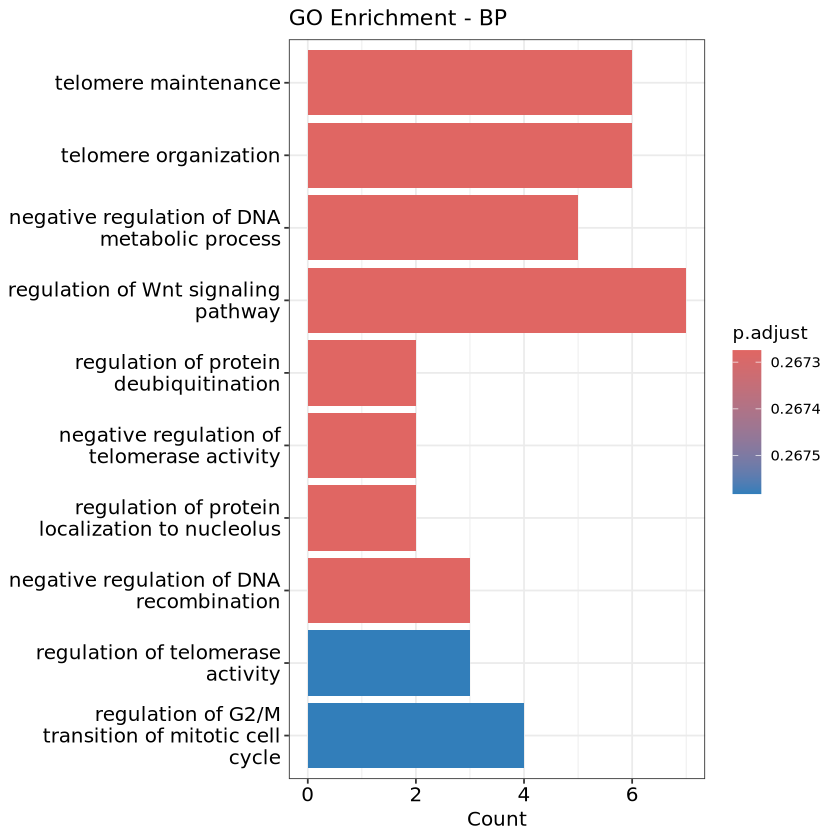

In [24]:
barplot(Aging2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [25]:
Aging2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [26]:
head(Aging2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000151,GO:0000151,ubiquitin ligase complex,6/98,335/22568,0.003431140,0.2893167,0.2673612,ENSG00000135108/ENSG00000174989/ENSG00000174943/ENSG00000123091/ENSG00000122550/ENSG00000127334,6
GO:0000776,GO:0000776,kinetochore,4/98,184/22568,0.008522171,0.2893167,0.2673612,ENSG00000076382/ENSG00000203760/ENSG00000254093/ENSG00000258724,4
GO:0005643,GO:0005643,nuclear pore,3/98,101/22568,0.009732853,0.2893167,0.2673612,ENSG00000184575/ENSG00000136243/ENSG00000183426,3
GO:0000779,GO:0000779,"condensed chromosome, centromeric region",4/98,195/22568,0.010390008,0.2893167,0.2673612,ENSG00000076382/ENSG00000203760/ENSG00000254093/ENSG00000258724,4
GO:0031463,GO:0031463,Cul3-RING ubiquitin ligase complex,2/98,36/22568,0.010682157,0.2893167,0.2673612,ENSG00000174943/ENSG00000122550,2
GO:0032587,GO:0032587,ruffle membrane,3/98,109/22568,0.011960148,0.2893167,0.2673612,ENSG00000088992/ENSG00000104643/ENSG00000124181,3
GO:0098978,GO:0098978,glutamatergic synapse,6/98,440/22568,0.012410046,0.2893167,0.2673612,ENSG00000102882/ENSG00000221866/ENSG00000149927/ENSG00000124181/ENSG00000135905/ENSG00000110975,6
GO:0005741,GO:0005741,mitochondrial outer membrane,4/98,228/22568,0.017517690,0.2893167,0.2673612,ENSG00000126858/ENSG00000171552/ENSG00000145354/ENSG00000133104,4
GO:0016363,GO:0016363,nuclear matrix,3/98,134/22568,0.020675374,0.2893167,0.2673612,ENSG00000184575/ENSG00000159267/ENSG00000203760,3


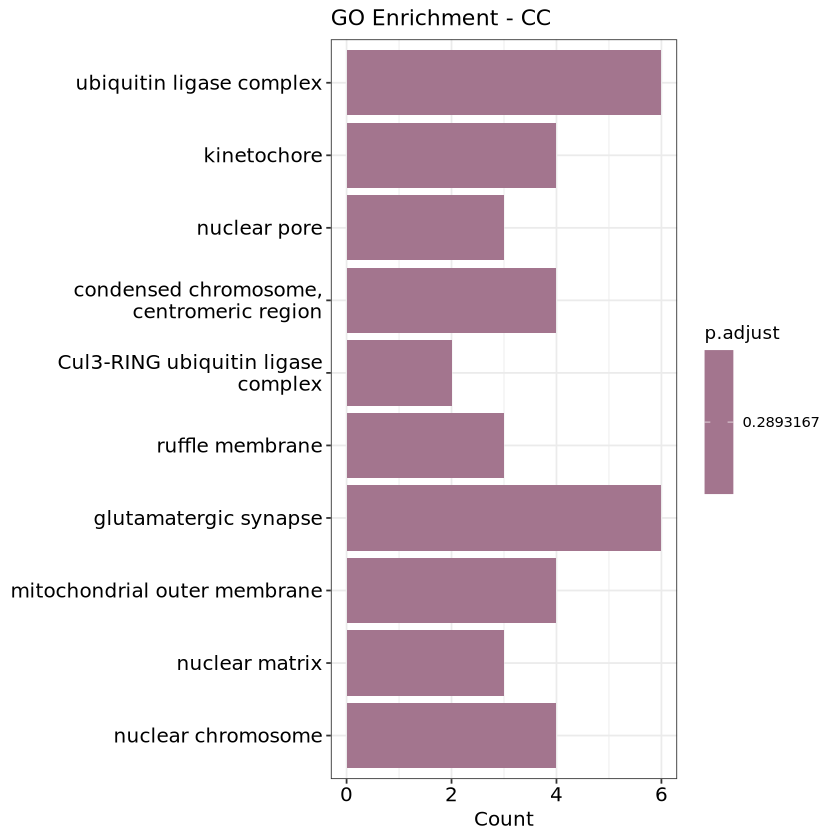

In [27]:
barplot(Aging2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [28]:
image_Aging2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [29]:
head(image_Aging2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000400,GO:0000400,four-way junction DNA binding,2/94,18/21059,0.002878913,0.1838948,0.1611827,ENSG00000108384/ENSG00000116062,2
GO:0000287,GO:0000287,magnesium ion binding,5/94,241/21059,0.004525432,0.1838948,0.1611827,ENSG00000088992/ENSG00000116062/ENSG00000086015/ENSG00000069020/ENSG00000127334,5
GO:0004674,GO:0004674,protein serine/threonine kinase activity,7/94,467/21059,0.004922961,0.1838948,0.1611827,ENSG00000102882/ENSG00000149930/ENSG00000006062/ENSG00000121989/ENSG00000086015/ENSG00000069020/ENSG00000127334,7
GO:0140664,GO:0140664,ATP-dependent DNA damage sensor activity,2/94,24/21059,0.005103780,0.1838948,0.1611827,ENSG00000108384/ENSG00000116062,2
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",2/94,26/21059,0.005975187,0.1838948,0.1611827,ENSG00000183336/ENSG00000145354,2
GO:0004709,GO:0004709,MAP kinase kinase kinase activity,2/94,27/21059,0.006434556,0.1838948,0.1611827,ENSG00000149930/ENSG00000006062,2
GO:0106310,GO:0106310,protein serine kinase activity,6/94,377/21059,0.006875037,0.1838948,0.1611827,ENSG00000102882/ENSG00000149930/ENSG00000006062/ENSG00000086015/ENSG00000069020/ENSG00000127334,6
GO:0070034,GO:0070034,telomerase RNA binding,2/94,28/21059,0.006909506,0.1838948,0.1611827,ENSG00000254093/ENSG00000258724,2
GO:0140612,GO:0140612,DNA damage sensor activity,2/94,28/21059,0.006909506,0.1838948,0.1611827,ENSG00000108384/ENSG00000116062,2


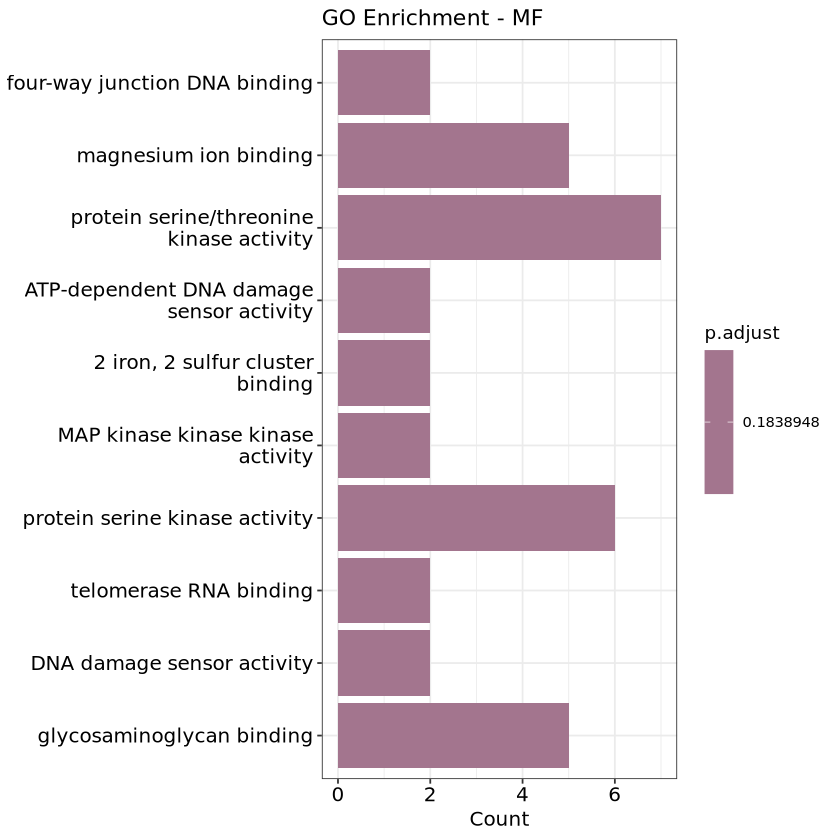

In [30]:
barplot(image_Aging2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [31]:
entrez_ids <- bitr(image_Aging2_gene$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_Aging2_gene$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“1.87% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [32]:
kegg_enrich %>% head(n=25)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04064,Environmental Information Processing,Signal transduction,hsa04064,NF-kappa B signaling pathway,4/39,105/9446,0.0008791736,0.07141933,0.05422693,9020/598/5335/4790,4
hsa04660,Organismal Systems,Immune system,hsa04660,T cell receptor signaling pathway,4/39,122/9446,0.0015362535,0.07141933,0.05422693,5595/9020/5335/4790,4
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,5/39,216/9446,0.0018242474,0.07141933,0.05422693,5595/598/5335/10010/4790,5
hsa04210,Cellular Processes,Cell growth and death,hsa04210,Apoptosis,4/39,137/9446,0.0023498797,0.07141933,0.05422693,5595/9020/598/4790,4
hsa05120,Human Diseases,Infectious disease: bacterial,hsa05120,Epithelial cell signaling in Helicobacter pylori infection,3/39,71/9446,0.0030637377,0.07141933,0.05422693,9020/5335/4790,3
hsa01524,Human Diseases,Drug resistance: antineoplastic,hsa01524,Platinum drug resistance,3/39,75/9446,0.0035787134,0.07141933,0.05422693,5595/2956/598,3
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,5/39,253/9446,0.0036236957,0.07141933,0.05422693,5595/598/5335/4790/10318,5
hsa05212,Human Diseases,Cancer: specific types,hsa05212,Pancreatic cancer,3/39,77/9446,0.0038548727,0.07141933,0.05422693,5595/598/4790,3
hsa05220,Human Diseases,Cancer: specific types,hsa05220,Chronic myeloid leukemia,3/39,77/9446,0.0038548727,0.07141933,0.05422693,5595/598/4790,3


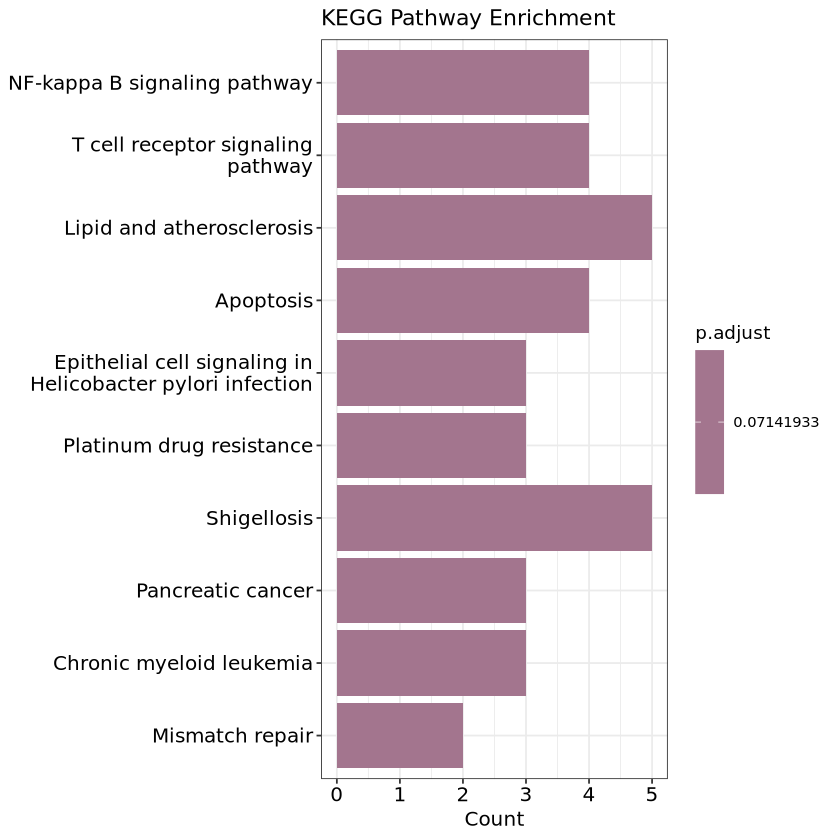

In [33]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")